# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

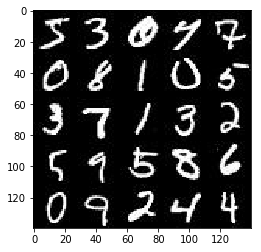

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

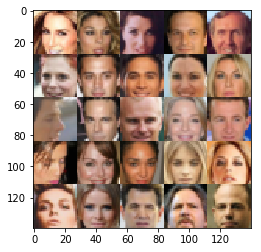

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\hnie\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        dropout = 0.7
        #input layer is 28*28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2 ,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, dropout)
        #now is 14*14*64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, dropout)
        #now is 7*7*128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, dropout)
        #now is 4*4*256
        
        x4 = tf.layers.conv2d(drop3, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        drop4 = tf.nn.dropout(relu4, dropout)
        #now is 4*4*512
        
        flat = tf.reshape(drop4, [-1, 4*4*512])
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.nn.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #first fully connected
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        #reshape
        alpha = 0.2
        dropout = 0.4
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, dropout)
        #now is 7*7*512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #now is 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #now is 28*28*128
        
        #output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.nn.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    global_step = tf.Variable(0, trainable=False)
    d_learning_rate = tf.train.exponential_decay(learning_rate[0], global_step, 100, 0.96, staircase=True)
    g_learning_rate = tf.train.exponential_decay(learning_rate[1], global_step, 100, 0.96, staircase=True)
    d_train_opt, _ = model_opt(d_loss, g_loss, d_learning_rate, beta1)
    _, g_train_opt = model_opt(d_loss, g_loss, g_learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    #samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim])
                batch_images = batch_images * 2
                #Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if(steps % 10 == 0):
                    #Get and print losses
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator loss: {:.4f}".format(train_loss_d),
                         "Generator loss: {:.4f}".format(train_loss_g))
                    #Save losses
                    #losses.append((train_loss_d, train_loss_g))
                
                if(steps % 100 == 0):
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            
        saver.save(sess, './checkpoints/generator.ckpt')
        print("Complete training!")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss: 0.5060 Generator loss: 3.8386
Epoch 1/2... Discriminator loss: 0.5995 Generator loss: 5.2095
Epoch 1/2... Discriminator loss: 0.6733 Generator loss: 7.1298
Epoch 1/2... Discriminator loss: 0.3907 Generator loss: 5.4079
Epoch 1/2... Discriminator loss: 1.1988 Generator loss: 9.6807
Epoch 1/2... Discriminator loss: 0.9982 Generator loss: 1.6765
Epoch 1/2... Discriminator loss: 0.9371 Generator loss: 5.2078
Epoch 1/2... Discriminator loss: 1.4195 Generator loss: 1.7575
Epoch 1/2... Discriminator loss: 1.6960 Generator loss: 1.9483
Epoch 1/2... Discriminator loss: 1.9167 Generator loss: 0.9864


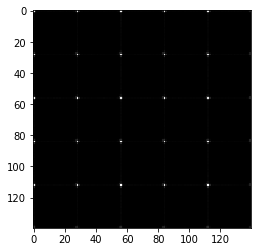

Epoch 1/2... Discriminator loss: 1.2897 Generator loss: 1.2467
Epoch 1/2... Discriminator loss: 1.5996 Generator loss: 0.5175
Epoch 1/2... Discriminator loss: 1.3415 Generator loss: 1.1037
Epoch 1/2... Discriminator loss: 1.4290 Generator loss: 1.6159
Epoch 1/2... Discriminator loss: 1.4975 Generator loss: 1.2134
Epoch 1/2... Discriminator loss: 1.5815 Generator loss: 0.8177
Epoch 1/2... Discriminator loss: 1.5610 Generator loss: 1.3237
Epoch 1/2... Discriminator loss: 1.4523 Generator loss: 1.2829
Epoch 1/2... Discriminator loss: 1.3295 Generator loss: 1.1281
Epoch 1/2... Discriminator loss: 1.3041 Generator loss: 1.1890


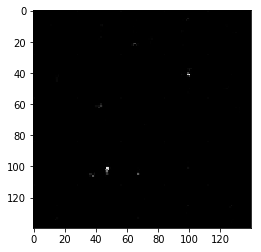

Epoch 1/2... Discriminator loss: 1.4603 Generator loss: 1.2606
Epoch 1/2... Discriminator loss: 1.3897 Generator loss: 1.2466
Epoch 1/2... Discriminator loss: 1.4449 Generator loss: 0.8755
Epoch 1/2... Discriminator loss: 1.5594 Generator loss: 1.4853
Epoch 1/2... Discriminator loss: 1.3298 Generator loss: 1.5508
Epoch 1/2... Discriminator loss: 1.2662 Generator loss: 1.0621
Epoch 1/2... Discriminator loss: 1.2790 Generator loss: 0.9609
Epoch 1/2... Discriminator loss: 1.4467 Generator loss: 0.7707
Epoch 1/2... Discriminator loss: 1.5387 Generator loss: 1.1774
Epoch 1/2... Discriminator loss: 1.5758 Generator loss: 0.8563


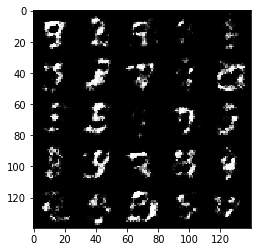

Epoch 1/2... Discriminator loss: 1.4217 Generator loss: 1.2378
Epoch 1/2... Discriminator loss: 1.5173 Generator loss: 1.1880
Epoch 1/2... Discriminator loss: 1.2519 Generator loss: 0.7016
Epoch 1/2... Discriminator loss: 1.5733 Generator loss: 0.8015
Epoch 1/2... Discriminator loss: 1.4138 Generator loss: 0.9284
Epoch 1/2... Discriminator loss: 1.2879 Generator loss: 0.9092
Epoch 1/2... Discriminator loss: 1.4466 Generator loss: 1.1635
Epoch 1/2... Discriminator loss: 1.2277 Generator loss: 1.2736
Epoch 1/2... Discriminator loss: 1.4519 Generator loss: 1.0253
Epoch 1/2... Discriminator loss: 1.4237 Generator loss: 0.6765


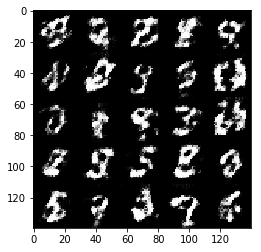

Epoch 1/2... Discriminator loss: 1.4796 Generator loss: 1.1667
Epoch 1/2... Discriminator loss: 1.5344 Generator loss: 0.6947
Epoch 1/2... Discriminator loss: 1.3256 Generator loss: 0.6779
Epoch 1/2... Discriminator loss: 1.3545 Generator loss: 1.2114
Epoch 1/2... Discriminator loss: 1.2466 Generator loss: 1.3448
Epoch 1/2... Discriminator loss: 1.3508 Generator loss: 0.9796
Epoch 1/2... Discriminator loss: 1.2500 Generator loss: 0.9253
Epoch 1/2... Discriminator loss: 1.3184 Generator loss: 0.9717
Epoch 1/2... Discriminator loss: 1.3704 Generator loss: 1.2851
Epoch 1/2... Discriminator loss: 1.2636 Generator loss: 1.4383


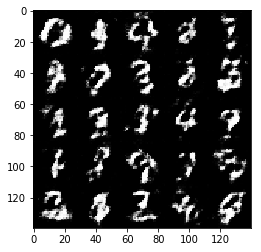

Epoch 1/2... Discriminator loss: 1.2570 Generator loss: 1.0194
Epoch 1/2... Discriminator loss: 1.2864 Generator loss: 1.2488
Epoch 1/2... Discriminator loss: 1.2174 Generator loss: 0.9072
Epoch 1/2... Discriminator loss: 1.3726 Generator loss: 0.8553
Epoch 1/2... Discriminator loss: 1.1832 Generator loss: 1.2066
Epoch 1/2... Discriminator loss: 1.2143 Generator loss: 1.3514
Epoch 1/2... Discriminator loss: 1.1238 Generator loss: 0.8601
Epoch 1/2... Discriminator loss: 1.2277 Generator loss: 1.3325
Epoch 1/2... Discriminator loss: 1.1804 Generator loss: 1.1480
Epoch 1/2... Discriminator loss: 1.1812 Generator loss: 0.7517


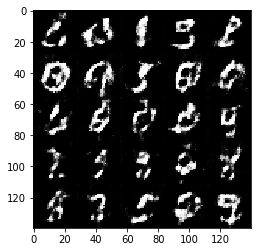

Epoch 1/2... Discriminator loss: 1.1945 Generator loss: 0.8712
Epoch 1/2... Discriminator loss: 1.4195 Generator loss: 1.3793
Epoch 1/2... Discriminator loss: 1.4248 Generator loss: 0.7784
Epoch 1/2... Discriminator loss: 1.2490 Generator loss: 0.9701
Epoch 1/2... Discriminator loss: 1.5628 Generator loss: 1.3592
Epoch 1/2... Discriminator loss: 1.4647 Generator loss: 1.3702
Epoch 1/2... Discriminator loss: 1.6507 Generator loss: 1.9715
Epoch 1/2... Discriminator loss: 1.3782 Generator loss: 0.9621
Epoch 1/2... Discriminator loss: 1.5433 Generator loss: 0.7859
Epoch 1/2... Discriminator loss: 1.3780 Generator loss: 1.1374


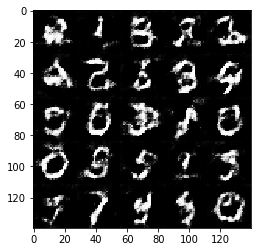

Epoch 1/2... Discriminator loss: 1.2392 Generator loss: 1.0834
Epoch 1/2... Discriminator loss: 1.2783 Generator loss: 1.0108
Epoch 1/2... Discriminator loss: 1.1669 Generator loss: 1.0681
Epoch 1/2... Discriminator loss: 1.3271 Generator loss: 1.0145
Epoch 1/2... Discriminator loss: 1.4446 Generator loss: 0.8919
Epoch 1/2... Discriminator loss: 1.2159 Generator loss: 1.1126
Epoch 1/2... Discriminator loss: 1.4880 Generator loss: 0.7879
Epoch 1/2... Discriminator loss: 1.2957 Generator loss: 1.2073
Epoch 1/2... Discriminator loss: 1.4090 Generator loss: 0.9541
Epoch 1/2... Discriminator loss: 1.3562 Generator loss: 1.0498


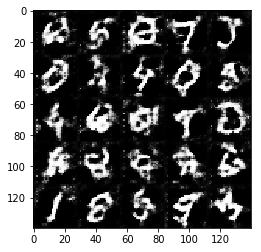

Epoch 1/2... Discriminator loss: 1.4401 Generator loss: 0.6399
Epoch 1/2... Discriminator loss: 1.1536 Generator loss: 1.1998
Epoch 1/2... Discriminator loss: 1.4099 Generator loss: 0.5844
Epoch 1/2... Discriminator loss: 1.3115 Generator loss: 0.9324
Epoch 1/2... Discriminator loss: 1.3863 Generator loss: 1.2967
Epoch 1/2... Discriminator loss: 1.2932 Generator loss: 0.7744
Epoch 1/2... Discriminator loss: 1.1965 Generator loss: 1.2178
Epoch 1/2... Discriminator loss: 1.3718 Generator loss: 0.6867
Epoch 1/2... Discriminator loss: 1.2526 Generator loss: 1.1798
Epoch 1/2... Discriminator loss: 1.3989 Generator loss: 0.7126


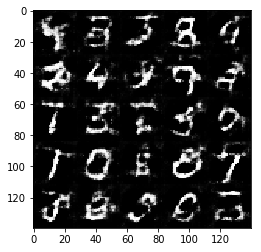

Epoch 1/2... Discriminator loss: 1.5284 Generator loss: 0.9608
Epoch 1/2... Discriminator loss: 1.2326 Generator loss: 1.4167
Epoch 1/2... Discriminator loss: 1.2190 Generator loss: 1.0920
Epoch 1/2... Discriminator loss: 1.1842 Generator loss: 0.9620
Epoch 1/2... Discriminator loss: 1.3246 Generator loss: 0.9057
Epoch 1/2... Discriminator loss: 1.3062 Generator loss: 0.7345
Epoch 1/2... Discriminator loss: 1.4325 Generator loss: 1.0619
Epoch 1/2... Discriminator loss: 1.2690 Generator loss: 1.3895
Epoch 1/2... Discriminator loss: 1.4620 Generator loss: 0.7245
Epoch 1/2... Discriminator loss: 1.3637 Generator loss: 1.1107


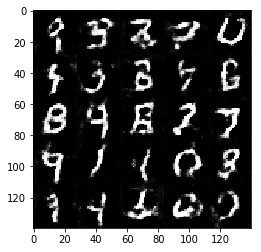

Epoch 1/2... Discriminator loss: 1.3673 Generator loss: 0.9520
Epoch 1/2... Discriminator loss: 1.4221 Generator loss: 1.0454
Epoch 1/2... Discriminator loss: 1.3476 Generator loss: 0.9432
Epoch 1/2... Discriminator loss: 1.2755 Generator loss: 1.0168
Epoch 1/2... Discriminator loss: 1.3636 Generator loss: 1.2816
Epoch 1/2... Discriminator loss: 1.3610 Generator loss: 0.7732
Epoch 1/2... Discriminator loss: 1.4098 Generator loss: 0.5978
Epoch 1/2... Discriminator loss: 1.2478 Generator loss: 1.0466
Epoch 1/2... Discriminator loss: 1.3935 Generator loss: 0.9780
Epoch 1/2... Discriminator loss: 1.2325 Generator loss: 0.9744


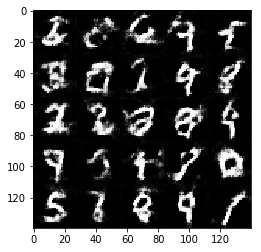

Epoch 1/2... Discriminator loss: 1.3068 Generator loss: 1.1061
Epoch 1/2... Discriminator loss: 1.2763 Generator loss: 1.0785
Epoch 1/2... Discriminator loss: 1.1076 Generator loss: 1.2161
Epoch 1/2... Discriminator loss: 1.1650 Generator loss: 0.9090
Epoch 1/2... Discriminator loss: 1.3458 Generator loss: 0.8625
Epoch 1/2... Discriminator loss: 1.4064 Generator loss: 1.0736
Epoch 1/2... Discriminator loss: 1.2606 Generator loss: 0.7506
Epoch 1/2... Discriminator loss: 1.3347 Generator loss: 1.0307
Epoch 1/2... Discriminator loss: 1.4153 Generator loss: 1.3842
Epoch 1/2... Discriminator loss: 1.4169 Generator loss: 0.9973


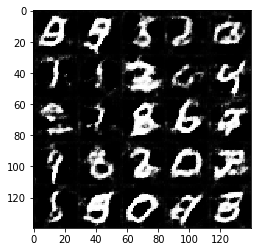

Epoch 1/2... Discriminator loss: 1.2522 Generator loss: 0.7980
Epoch 1/2... Discriminator loss: 1.4250 Generator loss: 0.8856
Epoch 1/2... Discriminator loss: 1.4415 Generator loss: 1.2463
Epoch 1/2... Discriminator loss: 1.3767 Generator loss: 0.8954
Epoch 1/2... Discriminator loss: 1.6052 Generator loss: 0.5789
Epoch 1/2... Discriminator loss: 1.2698 Generator loss: 0.8272
Epoch 1/2... Discriminator loss: 1.2645 Generator loss: 0.8534
Epoch 1/2... Discriminator loss: 1.1182 Generator loss: 0.9973
Epoch 1/2... Discriminator loss: 1.4315 Generator loss: 1.2167
Epoch 1/2... Discriminator loss: 1.2960 Generator loss: 1.1942


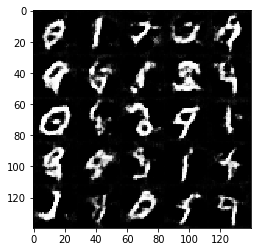

Epoch 1/2... Discriminator loss: 1.3045 Generator loss: 0.8518
Epoch 1/2... Discriminator loss: 1.2988 Generator loss: 1.0370
Epoch 1/2... Discriminator loss: 1.1138 Generator loss: 0.8910
Epoch 1/2... Discriminator loss: 1.3327 Generator loss: 1.1803
Epoch 1/2... Discriminator loss: 1.3436 Generator loss: 1.2109
Epoch 1/2... Discriminator loss: 1.6318 Generator loss: 0.5587
Epoch 1/2... Discriminator loss: 1.3985 Generator loss: 1.0521
Epoch 1/2... Discriminator loss: 1.2369 Generator loss: 1.0544
Epoch 1/2... Discriminator loss: 1.3420 Generator loss: 0.7841
Epoch 1/2... Discriminator loss: 1.5067 Generator loss: 1.1112


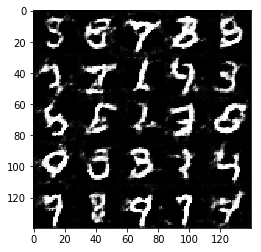

Epoch 1/2... Discriminator loss: 1.3569 Generator loss: 0.6887
Epoch 1/2... Discriminator loss: 1.5000 Generator loss: 0.5529
Epoch 1/2... Discriminator loss: 1.1388 Generator loss: 0.8635
Epoch 1/2... Discriminator loss: 1.4342 Generator loss: 0.5733
Epoch 1/2... Discriminator loss: 1.3864 Generator loss: 1.2488
Epoch 1/2... Discriminator loss: 1.2985 Generator loss: 1.3103
Epoch 1/2... Discriminator loss: 1.3073 Generator loss: 1.1173
Epoch 1/2... Discriminator loss: 1.4378 Generator loss: 1.2445
Epoch 1/2... Discriminator loss: 1.1190 Generator loss: 1.0708
Epoch 1/2... Discriminator loss: 1.3494 Generator loss: 0.9400


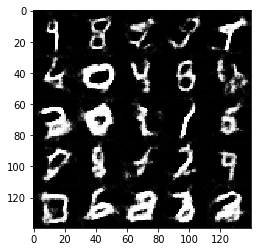

Epoch 1/2... Discriminator loss: 1.4752 Generator loss: 1.0015
Epoch 1/2... Discriminator loss: 1.2633 Generator loss: 0.8188
Epoch 1/2... Discriminator loss: 1.4015 Generator loss: 0.9795
Epoch 1/2... Discriminator loss: 1.3211 Generator loss: 0.8251
Epoch 1/2... Discriminator loss: 1.1653 Generator loss: 0.8372
Epoch 1/2... Discriminator loss: 1.1790 Generator loss: 0.9657
Epoch 1/2... Discriminator loss: 1.3537 Generator loss: 1.0902
Epoch 1/2... Discriminator loss: 1.2530 Generator loss: 0.9698
Epoch 1/2... Discriminator loss: 1.2271 Generator loss: 1.1891
Epoch 1/2... Discriminator loss: 1.3773 Generator loss: 0.8041


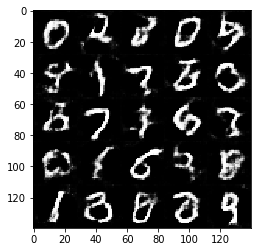

Epoch 1/2... Discriminator loss: 1.2773 Generator loss: 1.1007
Epoch 1/2... Discriminator loss: 1.0820 Generator loss: 1.0521
Epoch 1/2... Discriminator loss: 1.4602 Generator loss: 1.1432
Epoch 1/2... Discriminator loss: 1.2289 Generator loss: 1.2227
Epoch 1/2... Discriminator loss: 1.3557 Generator loss: 0.9388
Epoch 1/2... Discriminator loss: 1.1340 Generator loss: 1.3069
Epoch 1/2... Discriminator loss: 1.3170 Generator loss: 1.0994
Epoch 1/2... Discriminator loss: 1.3913 Generator loss: 0.7922
Epoch 1/2... Discriminator loss: 1.3813 Generator loss: 0.6278
Epoch 1/2... Discriminator loss: 1.3172 Generator loss: 1.0315


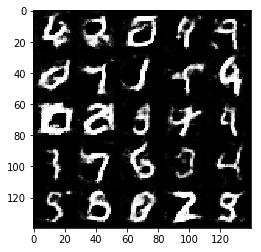

Epoch 1/2... Discriminator loss: 1.1429 Generator loss: 0.9487
Epoch 1/2... Discriminator loss: 1.1659 Generator loss: 1.0077
Epoch 1/2... Discriminator loss: 1.3295 Generator loss: 1.3671
Epoch 1/2... Discriminator loss: 1.2745 Generator loss: 0.9731
Epoch 1/2... Discriminator loss: 1.3471 Generator loss: 0.9129
Epoch 1/2... Discriminator loss: 1.2676 Generator loss: 0.6750
Epoch 1/2... Discriminator loss: 1.2735 Generator loss: 0.9612
Epoch 1/2... Discriminator loss: 1.3106 Generator loss: 0.8902
Epoch 1/2... Discriminator loss: 1.2049 Generator loss: 0.8356
Epoch 1/2... Discriminator loss: 1.1962 Generator loss: 1.5203


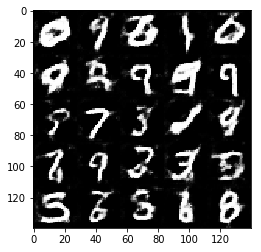

Epoch 1/2... Discriminator loss: 1.5280 Generator loss: 1.2681
Epoch 1/2... Discriminator loss: 1.3360 Generator loss: 0.9183
Epoch 1/2... Discriminator loss: 1.2574 Generator loss: 1.1006
Epoch 1/2... Discriminator loss: 1.2271 Generator loss: 1.2937
Epoch 1/2... Discriminator loss: 1.2900 Generator loss: 0.9420
Epoch 1/2... Discriminator loss: 1.2052 Generator loss: 0.6524
Epoch 1/2... Discriminator loss: 1.2797 Generator loss: 1.2024
Epoch 2/2... Discriminator loss: 1.1259 Generator loss: 1.4672
Epoch 2/2... Discriminator loss: 1.2734 Generator loss: 0.6739
Epoch 2/2... Discriminator loss: 1.1893 Generator loss: 0.9740


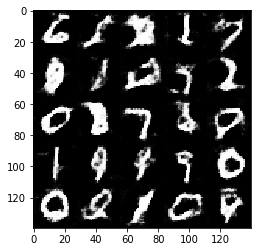

Epoch 2/2... Discriminator loss: 1.1892 Generator loss: 1.0042
Epoch 2/2... Discriminator loss: 1.0852 Generator loss: 0.8036
Epoch 2/2... Discriminator loss: 1.3343 Generator loss: 1.0454
Epoch 2/2... Discriminator loss: 1.2506 Generator loss: 0.9237
Epoch 2/2... Discriminator loss: 1.2667 Generator loss: 1.0155
Epoch 2/2... Discriminator loss: 1.2546 Generator loss: 1.0622
Epoch 2/2... Discriminator loss: 1.4255 Generator loss: 1.4563
Epoch 2/2... Discriminator loss: 1.3240 Generator loss: 0.6366
Epoch 2/2... Discriminator loss: 1.2389 Generator loss: 0.9576
Epoch 2/2... Discriminator loss: 1.2154 Generator loss: 0.8815


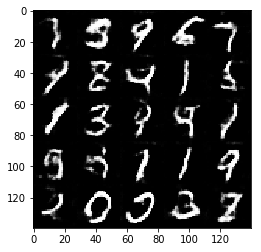

Epoch 2/2... Discriminator loss: 1.3859 Generator loss: 0.7374
Epoch 2/2... Discriminator loss: 1.3181 Generator loss: 0.7474
Epoch 2/2... Discriminator loss: 1.3576 Generator loss: 0.7888
Epoch 2/2... Discriminator loss: 1.3046 Generator loss: 1.0291
Epoch 2/2... Discriminator loss: 1.2230 Generator loss: 0.9823
Epoch 2/2... Discriminator loss: 1.0291 Generator loss: 1.0431
Epoch 2/2... Discriminator loss: 1.3881 Generator loss: 0.7165
Epoch 2/2... Discriminator loss: 1.1486 Generator loss: 1.0574
Epoch 2/2... Discriminator loss: 1.3570 Generator loss: 0.8381
Epoch 2/2... Discriminator loss: 1.4391 Generator loss: 1.2230


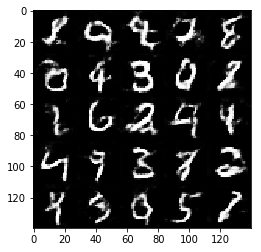

Epoch 2/2... Discriminator loss: 1.2999 Generator loss: 0.9091
Epoch 2/2... Discriminator loss: 1.1888 Generator loss: 0.6811
Epoch 2/2... Discriminator loss: 1.3442 Generator loss: 0.6662
Epoch 2/2... Discriminator loss: 1.3868 Generator loss: 0.7581
Epoch 2/2... Discriminator loss: 1.1738 Generator loss: 1.1317
Epoch 2/2... Discriminator loss: 1.1788 Generator loss: 1.1556
Epoch 2/2... Discriminator loss: 1.4629 Generator loss: 1.4431
Epoch 2/2... Discriminator loss: 1.3480 Generator loss: 0.9651
Epoch 2/2... Discriminator loss: 1.2724 Generator loss: 0.9272
Epoch 2/2... Discriminator loss: 1.2506 Generator loss: 0.6442


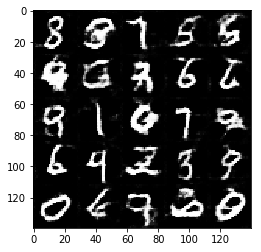

Epoch 2/2... Discriminator loss: 1.2246 Generator loss: 0.7188
Epoch 2/2... Discriminator loss: 1.3060 Generator loss: 1.3982
Epoch 2/2... Discriminator loss: 1.2316 Generator loss: 0.8929
Epoch 2/2... Discriminator loss: 1.3693 Generator loss: 1.4334
Epoch 2/2... Discriminator loss: 1.0641 Generator loss: 1.6036
Epoch 2/2... Discriminator loss: 1.1818 Generator loss: 1.2025
Epoch 2/2... Discriminator loss: 1.2998 Generator loss: 1.5591
Epoch 2/2... Discriminator loss: 1.2370 Generator loss: 0.8604
Epoch 2/2... Discriminator loss: 1.3185 Generator loss: 0.9818
Epoch 2/2... Discriminator loss: 1.1548 Generator loss: 1.1382


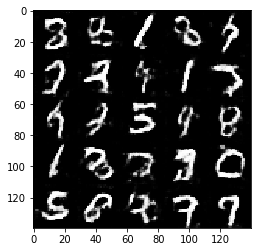

Epoch 2/2... Discriminator loss: 1.0533 Generator loss: 0.7729
Epoch 2/2... Discriminator loss: 1.4235 Generator loss: 1.0729
Epoch 2/2... Discriminator loss: 1.2950 Generator loss: 0.9157
Epoch 2/2... Discriminator loss: 1.2217 Generator loss: 1.3629
Epoch 2/2... Discriminator loss: 1.1930 Generator loss: 0.8249
Epoch 2/2... Discriminator loss: 1.2846 Generator loss: 0.6341
Epoch 2/2... Discriminator loss: 1.2770 Generator loss: 1.1154
Epoch 2/2... Discriminator loss: 1.3628 Generator loss: 1.4922
Epoch 2/2... Discriminator loss: 0.9397 Generator loss: 1.3839
Epoch 2/2... Discriminator loss: 1.2158 Generator loss: 0.9971


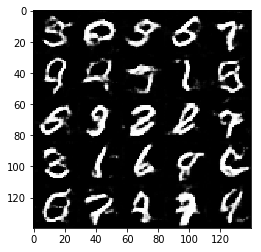

Epoch 2/2... Discriminator loss: 1.5011 Generator loss: 0.4478
Epoch 2/2... Discriminator loss: 1.3678 Generator loss: 0.6430
Epoch 2/2... Discriminator loss: 1.3692 Generator loss: 0.8481
Epoch 2/2... Discriminator loss: 1.2187 Generator loss: 0.4548
Epoch 2/2... Discriminator loss: 1.3096 Generator loss: 0.8037
Epoch 2/2... Discriminator loss: 1.4081 Generator loss: 0.9594
Epoch 2/2... Discriminator loss: 1.1355 Generator loss: 0.8092
Epoch 2/2... Discriminator loss: 1.4087 Generator loss: 0.9073
Epoch 2/2... Discriminator loss: 1.3869 Generator loss: 0.6578
Epoch 2/2... Discriminator loss: 1.5784 Generator loss: 0.6238


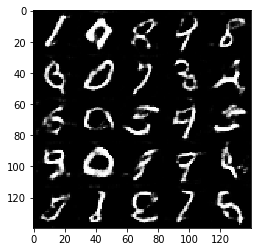

Epoch 2/2... Discriminator loss: 1.5090 Generator loss: 0.8074
Epoch 2/2... Discriminator loss: 1.1690 Generator loss: 1.3503
Epoch 2/2... Discriminator loss: 1.1261 Generator loss: 1.0504
Epoch 2/2... Discriminator loss: 1.2785 Generator loss: 0.7510
Epoch 2/2... Discriminator loss: 1.3218 Generator loss: 0.7182
Epoch 2/2... Discriminator loss: 1.0344 Generator loss: 1.1914
Epoch 2/2... Discriminator loss: 1.2434 Generator loss: 1.3296
Epoch 2/2... Discriminator loss: 1.1156 Generator loss: 1.1812
Epoch 2/2... Discriminator loss: 1.6392 Generator loss: 0.4610
Epoch 2/2... Discriminator loss: 0.9918 Generator loss: 0.9795


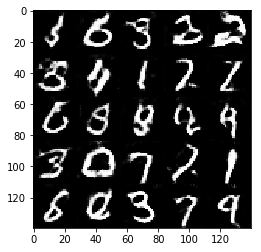

Epoch 2/2... Discriminator loss: 1.2181 Generator loss: 0.9838
Epoch 2/2... Discriminator loss: 1.3519 Generator loss: 0.8356
Epoch 2/2... Discriminator loss: 1.2835 Generator loss: 0.9830
Epoch 2/2... Discriminator loss: 1.4870 Generator loss: 0.7924
Epoch 2/2... Discriminator loss: 1.1694 Generator loss: 1.1537
Epoch 2/2... Discriminator loss: 1.3379 Generator loss: 0.7935
Epoch 2/2... Discriminator loss: 1.4167 Generator loss: 1.0394
Epoch 2/2... Discriminator loss: 1.0189 Generator loss: 0.8594
Epoch 2/2... Discriminator loss: 1.3032 Generator loss: 0.7028
Epoch 2/2... Discriminator loss: 1.3125 Generator loss: 0.9392


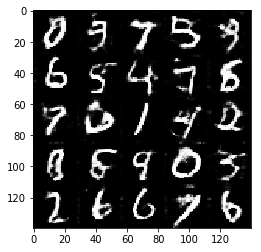

Epoch 2/2... Discriminator loss: 1.2631 Generator loss: 0.7172
Epoch 2/2... Discriminator loss: 1.2193 Generator loss: 1.0796
Epoch 2/2... Discriminator loss: 1.2654 Generator loss: 0.7537
Epoch 2/2... Discriminator loss: 1.1795 Generator loss: 0.7856
Epoch 2/2... Discriminator loss: 1.3442 Generator loss: 0.6634
Epoch 2/2... Discriminator loss: 1.2157 Generator loss: 0.6302
Epoch 2/2... Discriminator loss: 1.2982 Generator loss: 0.6770
Epoch 2/2... Discriminator loss: 1.1424 Generator loss: 1.0962
Epoch 2/2... Discriminator loss: 1.3067 Generator loss: 0.8624
Epoch 2/2... Discriminator loss: 1.3603 Generator loss: 0.8734


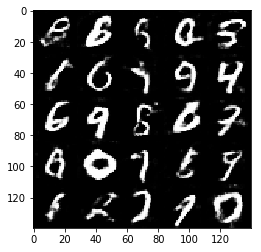

Epoch 2/2... Discriminator loss: 1.2588 Generator loss: 0.6461
Epoch 2/2... Discriminator loss: 1.1781 Generator loss: 1.2064
Epoch 2/2... Discriminator loss: 1.3430 Generator loss: 0.5214
Epoch 2/2... Discriminator loss: 1.1421 Generator loss: 0.9898
Epoch 2/2... Discriminator loss: 1.5857 Generator loss: 0.4875
Epoch 2/2... Discriminator loss: 1.4576 Generator loss: 0.5996
Epoch 2/2... Discriminator loss: 1.3850 Generator loss: 0.8141
Epoch 2/2... Discriminator loss: 1.4546 Generator loss: 0.9078
Epoch 2/2... Discriminator loss: 1.1974 Generator loss: 1.2742
Epoch 2/2... Discriminator loss: 1.3165 Generator loss: 0.8120


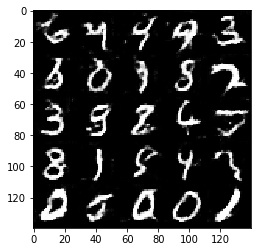

Epoch 2/2... Discriminator loss: 1.1800 Generator loss: 1.1495
Epoch 2/2... Discriminator loss: 1.4129 Generator loss: 1.3805
Epoch 2/2... Discriminator loss: 1.4720 Generator loss: 0.7440
Epoch 2/2... Discriminator loss: 1.3084 Generator loss: 1.0876
Epoch 2/2... Discriminator loss: 1.1104 Generator loss: 0.9843
Epoch 2/2... Discriminator loss: 1.2364 Generator loss: 0.7489
Epoch 2/2... Discriminator loss: 1.2183 Generator loss: 1.2027
Epoch 2/2... Discriminator loss: 1.3094 Generator loss: 1.4171
Epoch 2/2... Discriminator loss: 1.1974 Generator loss: 0.7438
Epoch 2/2... Discriminator loss: 1.3275 Generator loss: 0.5322


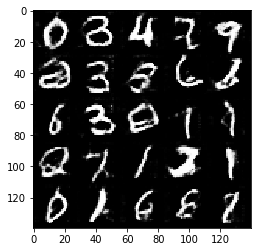

Epoch 2/2... Discriminator loss: 1.3092 Generator loss: 0.8995
Epoch 2/2... Discriminator loss: 1.4028 Generator loss: 0.8491
Epoch 2/2... Discriminator loss: 1.3093 Generator loss: 0.9696
Epoch 2/2... Discriminator loss: 1.4607 Generator loss: 1.1660
Epoch 2/2... Discriminator loss: 1.2703 Generator loss: 0.6549
Epoch 2/2... Discriminator loss: 1.1135 Generator loss: 1.3209
Epoch 2/2... Discriminator loss: 1.2851 Generator loss: 0.6663
Epoch 2/2... Discriminator loss: 1.1507 Generator loss: 0.9898
Epoch 2/2... Discriminator loss: 1.4443 Generator loss: 0.4885
Epoch 2/2... Discriminator loss: 1.6027 Generator loss: 0.5345


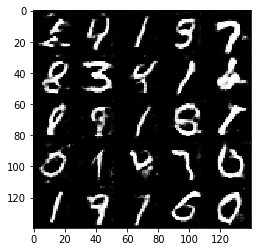

Epoch 2/2... Discriminator loss: 1.1794 Generator loss: 0.9318
Epoch 2/2... Discriminator loss: 1.3939 Generator loss: 0.8261
Epoch 2/2... Discriminator loss: 1.1911 Generator loss: 0.5998
Epoch 2/2... Discriminator loss: 1.1989 Generator loss: 1.1659
Epoch 2/2... Discriminator loss: 1.0321 Generator loss: 1.2005
Epoch 2/2... Discriminator loss: 1.3139 Generator loss: 0.9561
Epoch 2/2... Discriminator loss: 1.1686 Generator loss: 1.0388
Epoch 2/2... Discriminator loss: 1.1516 Generator loss: 0.8559
Epoch 2/2... Discriminator loss: 1.5705 Generator loss: 0.7241
Epoch 2/2... Discriminator loss: 1.2975 Generator loss: 0.9811


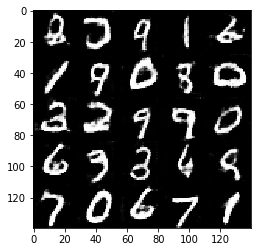

Epoch 2/2... Discriminator loss: 1.2264 Generator loss: 0.9290
Epoch 2/2... Discriminator loss: 1.4357 Generator loss: 0.7868
Epoch 2/2... Discriminator loss: 1.2582 Generator loss: 0.9403
Epoch 2/2... Discriminator loss: 1.3453 Generator loss: 1.1667
Epoch 2/2... Discriminator loss: 1.2465 Generator loss: 0.8590
Epoch 2/2... Discriminator loss: 1.0681 Generator loss: 1.2606
Epoch 2/2... Discriminator loss: 1.1689 Generator loss: 1.1997
Epoch 2/2... Discriminator loss: 1.0043 Generator loss: 0.9327
Epoch 2/2... Discriminator loss: 1.4270 Generator loss: 0.5060
Epoch 2/2... Discriminator loss: 1.3172 Generator loss: 0.8096


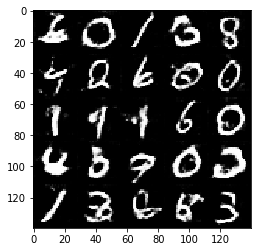

Epoch 2/2... Discriminator loss: 1.0738 Generator loss: 1.6274
Epoch 2/2... Discriminator loss: 1.3135 Generator loss: 0.8434
Epoch 2/2... Discriminator loss: 0.9806 Generator loss: 0.7682
Epoch 2/2... Discriminator loss: 1.4563 Generator loss: 1.5125
Epoch 2/2... Discriminator loss: 1.2961 Generator loss: 0.5952
Epoch 2/2... Discriminator loss: 1.0999 Generator loss: 0.7735
Epoch 2/2... Discriminator loss: 1.0905 Generator loss: 0.8799
Epoch 2/2... Discriminator loss: 1.1359 Generator loss: 1.2084
Epoch 2/2... Discriminator loss: 1.4334 Generator loss: 0.5406
Epoch 2/2... Discriminator loss: 1.2206 Generator loss: 1.5121


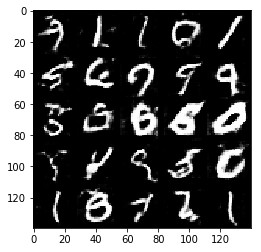

Epoch 2/2... Discriminator loss: 1.1208 Generator loss: 0.7567
Epoch 2/2... Discriminator loss: 1.4812 Generator loss: 0.7667
Epoch 2/2... Discriminator loss: 1.3345 Generator loss: 1.3959
Epoch 2/2... Discriminator loss: 1.0363 Generator loss: 1.4619
Epoch 2/2... Discriminator loss: 1.2393 Generator loss: 0.6824
Epoch 2/2... Discriminator loss: 1.5484 Generator loss: 0.7973
Epoch 2/2... Discriminator loss: 1.3159 Generator loss: 0.6770
Epoch 2/2... Discriminator loss: 1.2258 Generator loss: 0.7603
Epoch 2/2... Discriminator loss: 1.1715 Generator loss: 1.1358
Epoch 2/2... Discriminator loss: 1.1570 Generator loss: 0.7950


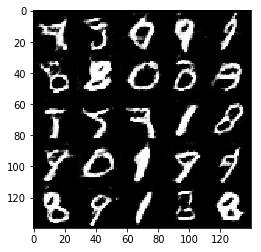

Epoch 2/2... Discriminator loss: 1.0799 Generator loss: 1.3222
Epoch 2/2... Discriminator loss: 0.9745 Generator loss: 0.9664
Epoch 2/2... Discriminator loss: 1.0133 Generator loss: 1.5009
Epoch 2/2... Discriminator loss: 1.1682 Generator loss: 1.2371
Epoch 2/2... Discriminator loss: 1.0844 Generator loss: 1.2567
Epoch 2/2... Discriminator loss: 1.1110 Generator loss: 1.2039
Epoch 2/2... Discriminator loss: 1.4291 Generator loss: 0.7182
Epoch 2/2... Discriminator loss: 1.1330 Generator loss: 0.9131
Epoch 2/2... Discriminator loss: 1.1954 Generator loss: 0.8791
Epoch 2/2... Discriminator loss: 1.0457 Generator loss: 1.3524


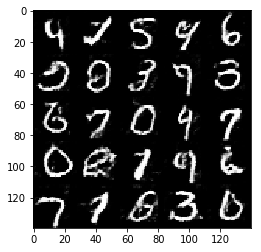

Epoch 2/2... Discriminator loss: 1.1508 Generator loss: 1.6540
Epoch 2/2... Discriminator loss: 1.1116 Generator loss: 1.2164
Epoch 2/2... Discriminator loss: 1.1268 Generator loss: 1.0944
Epoch 2/2... Discriminator loss: 0.9839 Generator loss: 0.6512
Epoch 2/2... Discriminator loss: 1.2172 Generator loss: 1.4268
Epoch 2/2... Discriminator loss: 1.2678 Generator loss: 0.7204
Epoch 2/2... Discriminator loss: 1.1800 Generator loss: 0.5421
Epoch 2/2... Discriminator loss: 1.4836 Generator loss: 0.4319
Epoch 2/2... Discriminator loss: 1.2235 Generator loss: 1.4721
Epoch 2/2... Discriminator loss: 1.3059 Generator loss: 0.8567


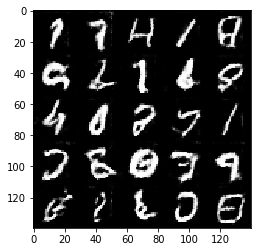

Epoch 2/2... Discriminator loss: 0.8882 Generator loss: 1.1737
Epoch 2/2... Discriminator loss: 0.9335 Generator loss: 1.0926
Epoch 2/2... Discriminator loss: 1.1915 Generator loss: 1.1596
Epoch 2/2... Discriminator loss: 1.1693 Generator loss: 0.8612
Epoch 2/2... Discriminator loss: 1.0817 Generator loss: 1.0655
Complete training!


In [13]:
batch_size = 32
z_dim = 100
learning_rate = (0.0001, 0.0002)
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss: 0.7881 Generator loss: 1.8391
Epoch 1/1... Discriminator loss: 0.7027 Generator loss: 2.1586
Epoch 1/1... Discriminator loss: 0.8595 Generator loss: 1.7508
Epoch 1/1... Discriminator loss: 1.1123 Generator loss: 1.6065
Epoch 1/1... Discriminator loss: 1.1304 Generator loss: 1.2213
Epoch 1/1... Discriminator loss: 0.7866 Generator loss: 2.3495
Epoch 1/1... Discriminator loss: 1.2839 Generator loss: 1.6216
Epoch 1/1... Discriminator loss: 1.0222 Generator loss: 1.7767
Epoch 1/1... Discriminator loss: 0.9502 Generator loss: 1.8287
Epoch 1/1... Discriminator loss: 0.6928 Generator loss: 2.2728


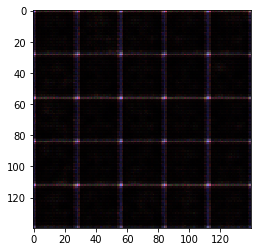

Epoch 1/1... Discriminator loss: 0.7367 Generator loss: 2.1134
Epoch 1/1... Discriminator loss: 0.7935 Generator loss: 1.9896
Epoch 1/1... Discriminator loss: 1.1061 Generator loss: 1.3834
Epoch 1/1... Discriminator loss: 0.8528 Generator loss: 1.5649
Epoch 1/1... Discriminator loss: 1.0916 Generator loss: 1.5767
Epoch 1/1... Discriminator loss: 0.9479 Generator loss: 1.9688
Epoch 1/1... Discriminator loss: 1.1767 Generator loss: 1.4770
Epoch 1/1... Discriminator loss: 1.3911 Generator loss: 1.2530
Epoch 1/1... Discriminator loss: 1.5470 Generator loss: 1.0916
Epoch 1/1... Discriminator loss: 1.1427 Generator loss: 1.2233


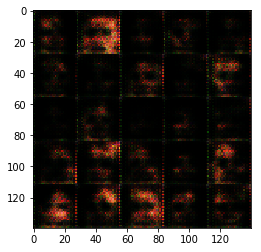

Epoch 1/1... Discriminator loss: 1.4887 Generator loss: 1.0321
Epoch 1/1... Discriminator loss: 1.2758 Generator loss: 1.3763
Epoch 1/1... Discriminator loss: 1.3546 Generator loss: 0.9344
Epoch 1/1... Discriminator loss: 1.0603 Generator loss: 1.1211
Epoch 1/1... Discriminator loss: 1.3349 Generator loss: 1.6401
Epoch 1/1... Discriminator loss: 1.2763 Generator loss: 2.1211
Epoch 1/1... Discriminator loss: 1.1489 Generator loss: 1.7597
Epoch 1/1... Discriminator loss: 1.2899 Generator loss: 2.0194
Epoch 1/1... Discriminator loss: 1.1820 Generator loss: 1.4157
Epoch 1/1... Discriminator loss: 1.5589 Generator loss: 1.2661


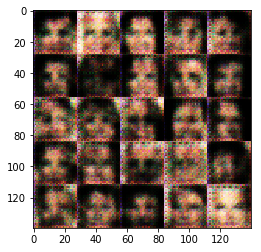

Epoch 1/1... Discriminator loss: 1.2943 Generator loss: 1.2753
Epoch 1/1... Discriminator loss: 1.3355 Generator loss: 1.2674
Epoch 1/1... Discriminator loss: 1.5424 Generator loss: 1.1063
Epoch 1/1... Discriminator loss: 1.0936 Generator loss: 1.4403
Epoch 1/1... Discriminator loss: 1.2403 Generator loss: 1.2370
Epoch 1/1... Discriminator loss: 1.0777 Generator loss: 1.9671
Epoch 1/1... Discriminator loss: 1.2893 Generator loss: 2.1874
Epoch 1/1... Discriminator loss: 1.1915 Generator loss: 1.6043
Epoch 1/1... Discriminator loss: 1.1625 Generator loss: 1.1534
Epoch 1/1... Discriminator loss: 1.0962 Generator loss: 1.8644


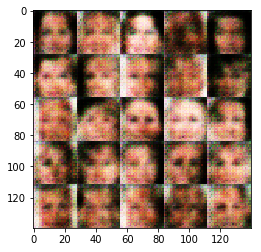

Epoch 1/1... Discriminator loss: 0.9952 Generator loss: 3.1035
Epoch 1/1... Discriminator loss: 1.2228 Generator loss: 1.3149
Epoch 1/1... Discriminator loss: 0.8115 Generator loss: 2.8853
Epoch 1/1... Discriminator loss: 1.9174 Generator loss: 0.6069
Epoch 1/1... Discriminator loss: 1.0318 Generator loss: 2.1539
Epoch 1/1... Discriminator loss: 1.3238 Generator loss: 0.8659
Epoch 1/1... Discriminator loss: 1.0760 Generator loss: 2.6029
Epoch 1/1... Discriminator loss: 1.4325 Generator loss: 1.0152
Epoch 1/1... Discriminator loss: 0.8547 Generator loss: 1.5632
Epoch 1/1... Discriminator loss: 1.4038 Generator loss: 1.3443


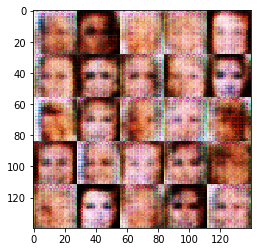

Epoch 1/1... Discriminator loss: 0.8449 Generator loss: 1.7957
Epoch 1/1... Discriminator loss: 0.9925 Generator loss: 1.7421
Epoch 1/1... Discriminator loss: 1.1722 Generator loss: 1.2298
Epoch 1/1... Discriminator loss: 1.1508 Generator loss: 1.3963
Epoch 1/1... Discriminator loss: 1.3813 Generator loss: 0.7070
Epoch 1/1... Discriminator loss: 0.5656 Generator loss: 2.3892
Epoch 1/1... Discriminator loss: 1.1973 Generator loss: 2.0418
Epoch 1/1... Discriminator loss: 0.9148 Generator loss: 1.9437
Epoch 1/1... Discriminator loss: 1.3134 Generator loss: 2.3915
Epoch 1/1... Discriminator loss: 1.4741 Generator loss: 0.8671


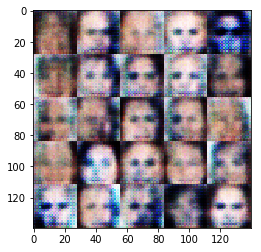

Epoch 1/1... Discriminator loss: 1.1190 Generator loss: 1.9509
Epoch 1/1... Discriminator loss: 1.0144 Generator loss: 1.5349
Epoch 1/1... Discriminator loss: 0.9715 Generator loss: 1.7826
Epoch 1/1... Discriminator loss: 1.4103 Generator loss: 1.2067
Epoch 1/1... Discriminator loss: 1.3820 Generator loss: 1.1488
Epoch 1/1... Discriminator loss: 1.4787 Generator loss: 0.6367
Epoch 1/1... Discriminator loss: 1.7565 Generator loss: 0.6645
Epoch 1/1... Discriminator loss: 1.7031 Generator loss: 0.9580
Epoch 1/1... Discriminator loss: 1.1554 Generator loss: 1.3423
Epoch 1/1... Discriminator loss: 1.5166 Generator loss: 1.1217


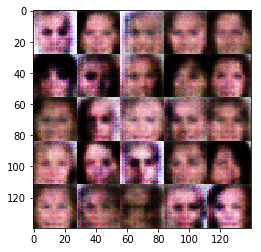

Epoch 1/1... Discriminator loss: 1.6597 Generator loss: 1.1556
Epoch 1/1... Discriminator loss: 1.1012 Generator loss: 1.3621
Epoch 1/1... Discriminator loss: 1.5610 Generator loss: 1.3797
Epoch 1/1... Discriminator loss: 1.1018 Generator loss: 2.0202
Epoch 1/1... Discriminator loss: 1.4896 Generator loss: 0.8264
Epoch 1/1... Discriminator loss: 1.5223 Generator loss: 1.2038
Epoch 1/1... Discriminator loss: 1.4144 Generator loss: 0.9612
Epoch 1/1... Discriminator loss: 1.1630 Generator loss: 1.4143
Epoch 1/1... Discriminator loss: 1.6467 Generator loss: 0.9254
Epoch 1/1... Discriminator loss: 1.0984 Generator loss: 1.3343


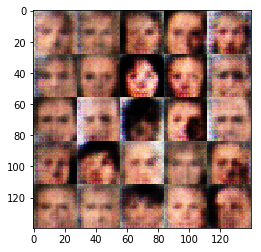

Epoch 1/1... Discriminator loss: 1.4561 Generator loss: 1.0944
Epoch 1/1... Discriminator loss: 1.0931 Generator loss: 1.4331
Epoch 1/1... Discriminator loss: 1.4015 Generator loss: 1.3377
Epoch 1/1... Discriminator loss: 1.5316 Generator loss: 0.9258
Epoch 1/1... Discriminator loss: 1.3216 Generator loss: 0.6174
Epoch 1/1... Discriminator loss: 1.3065 Generator loss: 1.3743
Epoch 1/1... Discriminator loss: 1.1495 Generator loss: 2.0701
Epoch 1/1... Discriminator loss: 1.6165 Generator loss: 1.1872
Epoch 1/1... Discriminator loss: 1.0690 Generator loss: 1.7121
Epoch 1/1... Discriminator loss: 1.7586 Generator loss: 0.8041


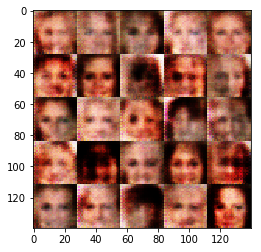

Epoch 1/1... Discriminator loss: 1.3399 Generator loss: 0.6695
Epoch 1/1... Discriminator loss: 1.4191 Generator loss: 1.2232
Epoch 1/1... Discriminator loss: 1.3686 Generator loss: 1.9276
Epoch 1/1... Discriminator loss: 1.7300 Generator loss: 1.0852
Epoch 1/1... Discriminator loss: 1.1988 Generator loss: 1.2630
Epoch 1/1... Discriminator loss: 1.5043 Generator loss: 0.9475
Epoch 1/1... Discriminator loss: 1.2309 Generator loss: 0.9930
Epoch 1/1... Discriminator loss: 1.2670 Generator loss: 1.0949
Epoch 1/1... Discriminator loss: 1.0716 Generator loss: 1.9466
Epoch 1/1... Discriminator loss: 1.4718 Generator loss: 1.2651


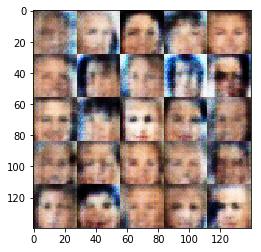

Epoch 1/1... Discriminator loss: 1.3208 Generator loss: 1.0948
Epoch 1/1... Discriminator loss: 0.9967 Generator loss: 1.7657
Epoch 1/1... Discriminator loss: 1.1563 Generator loss: 0.8169
Epoch 1/1... Discriminator loss: 1.4720 Generator loss: 0.9191
Epoch 1/1... Discriminator loss: 1.4493 Generator loss: 1.4199
Epoch 1/1... Discriminator loss: 1.3233 Generator loss: 1.1292
Epoch 1/1... Discriminator loss: 1.0248 Generator loss: 1.3332
Epoch 1/1... Discriminator loss: 1.2482 Generator loss: 1.0669
Epoch 1/1... Discriminator loss: 1.1343 Generator loss: 1.4336
Epoch 1/1... Discriminator loss: 1.2292 Generator loss: 1.3831


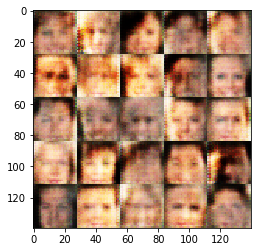

Epoch 1/1... Discriminator loss: 1.4015 Generator loss: 1.3302
Epoch 1/1... Discriminator loss: 1.2145 Generator loss: 1.3841
Epoch 1/1... Discriminator loss: 1.2043 Generator loss: 1.6822
Epoch 1/1... Discriminator loss: 1.2457 Generator loss: 1.0515
Epoch 1/1... Discriminator loss: 1.3051 Generator loss: 1.1460
Epoch 1/1... Discriminator loss: 1.5068 Generator loss: 1.9496
Epoch 1/1... Discriminator loss: 1.2667 Generator loss: 1.0908
Epoch 1/1... Discriminator loss: 1.3844 Generator loss: 0.8328
Epoch 1/1... Discriminator loss: 1.3812 Generator loss: 0.9934
Epoch 1/1... Discriminator loss: 1.4530 Generator loss: 0.9340


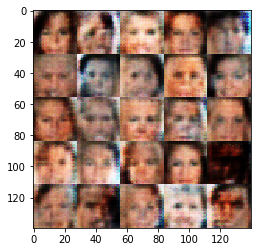

Epoch 1/1... Discriminator loss: 1.3652 Generator loss: 0.7794
Epoch 1/1... Discriminator loss: 1.2542 Generator loss: 1.0182
Epoch 1/1... Discriminator loss: 1.1903 Generator loss: 1.5336
Epoch 1/1... Discriminator loss: 1.5333 Generator loss: 0.7872
Epoch 1/1... Discriminator loss: 1.4674 Generator loss: 0.8594
Epoch 1/1... Discriminator loss: 1.4763 Generator loss: 0.9419
Epoch 1/1... Discriminator loss: 1.4049 Generator loss: 0.9215
Epoch 1/1... Discriminator loss: 1.3998 Generator loss: 0.9063
Epoch 1/1... Discriminator loss: 1.3961 Generator loss: 1.1885
Epoch 1/1... Discriminator loss: 1.4931 Generator loss: 0.8944


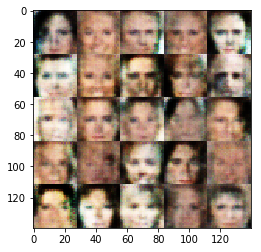

Epoch 1/1... Discriminator loss: 1.3939 Generator loss: 0.9962
Epoch 1/1... Discriminator loss: 1.2640 Generator loss: 0.9988
Epoch 1/1... Discriminator loss: 1.2284 Generator loss: 1.0270
Epoch 1/1... Discriminator loss: 1.2238 Generator loss: 1.0656
Epoch 1/1... Discriminator loss: 1.3708 Generator loss: 0.9058
Epoch 1/1... Discriminator loss: 1.4964 Generator loss: 0.9785
Epoch 1/1... Discriminator loss: 1.1695 Generator loss: 1.3604
Epoch 1/1... Discriminator loss: 1.3955 Generator loss: 0.9367
Epoch 1/1... Discriminator loss: 1.7677 Generator loss: 0.5733
Epoch 1/1... Discriminator loss: 1.4960 Generator loss: 1.1293


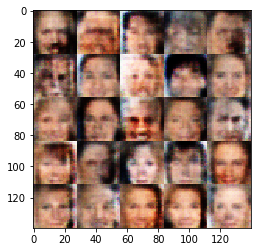

Epoch 1/1... Discriminator loss: 1.4592 Generator loss: 0.9200
Epoch 1/1... Discriminator loss: 1.7505 Generator loss: 0.7357
Epoch 1/1... Discriminator loss: 1.5074 Generator loss: 0.8661
Epoch 1/1... Discriminator loss: 1.1463 Generator loss: 1.1013
Epoch 1/1... Discriminator loss: 1.4089 Generator loss: 0.9649
Epoch 1/1... Discriminator loss: 1.3207 Generator loss: 1.1467
Epoch 1/1... Discriminator loss: 1.4058 Generator loss: 1.0678
Epoch 1/1... Discriminator loss: 1.2555 Generator loss: 0.8205
Epoch 1/1... Discriminator loss: 1.5126 Generator loss: 0.7055
Epoch 1/1... Discriminator loss: 1.1392 Generator loss: 0.9932


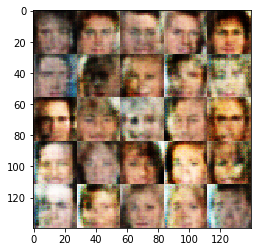

Epoch 1/1... Discriminator loss: 1.4030 Generator loss: 0.9539
Epoch 1/1... Discriminator loss: 1.4995 Generator loss: 0.8826
Epoch 1/1... Discriminator loss: 1.5102 Generator loss: 0.9434
Epoch 1/1... Discriminator loss: 1.4036 Generator loss: 1.2021
Epoch 1/1... Discriminator loss: 1.4982 Generator loss: 1.0450
Epoch 1/1... Discriminator loss: 1.1753 Generator loss: 1.0097
Epoch 1/1... Discriminator loss: 1.2548 Generator loss: 0.8018
Epoch 1/1... Discriminator loss: 1.4323 Generator loss: 0.9220
Epoch 1/1... Discriminator loss: 1.4874 Generator loss: 0.8586
Epoch 1/1... Discriminator loss: 1.5121 Generator loss: 1.0041


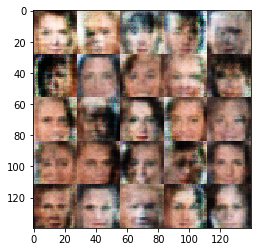

Epoch 1/1... Discriminator loss: 1.5670 Generator loss: 0.8766
Epoch 1/1... Discriminator loss: 1.5026 Generator loss: 0.8253
Epoch 1/1... Discriminator loss: 1.4081 Generator loss: 0.8692
Epoch 1/1... Discriminator loss: 1.4091 Generator loss: 1.0234
Epoch 1/1... Discriminator loss: 1.2060 Generator loss: 0.8612
Epoch 1/1... Discriminator loss: 1.4916 Generator loss: 0.7338
Epoch 1/1... Discriminator loss: 1.5084 Generator loss: 1.0486
Epoch 1/1... Discriminator loss: 1.3207 Generator loss: 0.9710
Epoch 1/1... Discriminator loss: 1.2723 Generator loss: 1.1031
Epoch 1/1... Discriminator loss: 1.5027 Generator loss: 1.0391


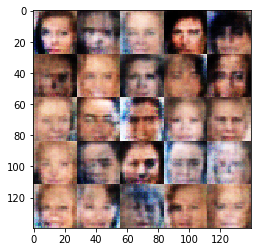

Epoch 1/1... Discriminator loss: 1.4045 Generator loss: 1.0934
Epoch 1/1... Discriminator loss: 1.4699 Generator loss: 1.0020
Epoch 1/1... Discriminator loss: 1.3758 Generator loss: 0.9602
Epoch 1/1... Discriminator loss: 1.4529 Generator loss: 1.0085
Epoch 1/1... Discriminator loss: 1.4444 Generator loss: 0.9312
Epoch 1/1... Discriminator loss: 1.4233 Generator loss: 0.8873
Epoch 1/1... Discriminator loss: 1.3641 Generator loss: 0.7132
Epoch 1/1... Discriminator loss: 1.3006 Generator loss: 0.9092
Epoch 1/1... Discriminator loss: 1.4497 Generator loss: 0.9437
Epoch 1/1... Discriminator loss: 1.5093 Generator loss: 0.8640


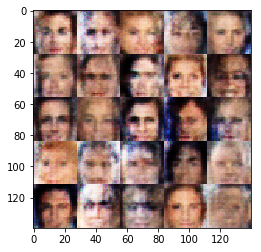

Epoch 1/1... Discriminator loss: 1.2697 Generator loss: 0.8444
Epoch 1/1... Discriminator loss: 1.4028 Generator loss: 0.8354
Epoch 1/1... Discriminator loss: 1.3536 Generator loss: 0.9342
Epoch 1/1... Discriminator loss: 1.5800 Generator loss: 0.6811
Epoch 1/1... Discriminator loss: 1.3402 Generator loss: 0.8256
Epoch 1/1... Discriminator loss: 1.5200 Generator loss: 0.7870
Epoch 1/1... Discriminator loss: 1.4084 Generator loss: 0.7360
Epoch 1/1... Discriminator loss: 1.4616 Generator loss: 0.9624
Epoch 1/1... Discriminator loss: 1.3123 Generator loss: 0.8157
Epoch 1/1... Discriminator loss: 1.3705 Generator loss: 0.8465


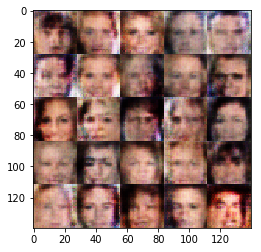

Epoch 1/1... Discriminator loss: 1.5654 Generator loss: 0.9630
Epoch 1/1... Discriminator loss: 1.4419 Generator loss: 0.7504
Epoch 1/1... Discriminator loss: 1.2293 Generator loss: 0.9220
Epoch 1/1... Discriminator loss: 1.4604 Generator loss: 0.9743
Epoch 1/1... Discriminator loss: 1.5674 Generator loss: 0.9357
Epoch 1/1... Discriminator loss: 1.4956 Generator loss: 0.8760
Epoch 1/1... Discriminator loss: 1.2923 Generator loss: 0.8657
Epoch 1/1... Discriminator loss: 1.5617 Generator loss: 0.9593
Epoch 1/1... Discriminator loss: 1.4472 Generator loss: 1.0671
Epoch 1/1... Discriminator loss: 1.3169 Generator loss: 1.1238


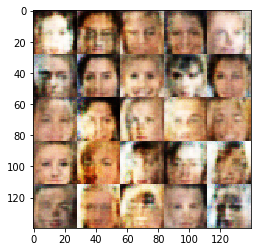

Epoch 1/1... Discriminator loss: 1.3798 Generator loss: 1.1297
Epoch 1/1... Discriminator loss: 1.6411 Generator loss: 0.8168
Epoch 1/1... Discriminator loss: 1.4605 Generator loss: 0.9201
Epoch 1/1... Discriminator loss: 1.4302 Generator loss: 0.9207
Epoch 1/1... Discriminator loss: 1.4863 Generator loss: 0.8692
Epoch 1/1... Discriminator loss: 1.3914 Generator loss: 0.8735
Epoch 1/1... Discriminator loss: 1.4291 Generator loss: 0.8939
Epoch 1/1... Discriminator loss: 1.5246 Generator loss: 0.8672
Epoch 1/1... Discriminator loss: 1.4943 Generator loss: 1.0603
Epoch 1/1... Discriminator loss: 1.4120 Generator loss: 0.7160


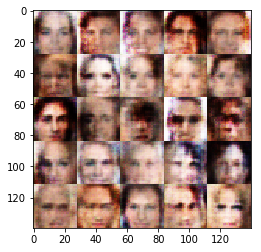

Epoch 1/1... Discriminator loss: 1.2103 Generator loss: 1.0565
Epoch 1/1... Discriminator loss: 1.5296 Generator loss: 0.7992
Epoch 1/1... Discriminator loss: 1.3360 Generator loss: 0.8264
Epoch 1/1... Discriminator loss: 1.3787 Generator loss: 0.8181
Epoch 1/1... Discriminator loss: 1.4028 Generator loss: 0.7739
Epoch 1/1... Discriminator loss: 1.4809 Generator loss: 0.9571
Epoch 1/1... Discriminator loss: 1.2482 Generator loss: 0.9319
Epoch 1/1... Discriminator loss: 1.3441 Generator loss: 1.0257
Epoch 1/1... Discriminator loss: 1.3885 Generator loss: 1.1058
Epoch 1/1... Discriminator loss: 1.2861 Generator loss: 0.8364


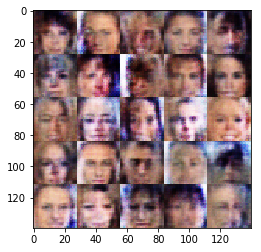

Epoch 1/1... Discriminator loss: 1.4165 Generator loss: 1.1078
Epoch 1/1... Discriminator loss: 1.3416 Generator loss: 1.0296
Epoch 1/1... Discriminator loss: 1.4289 Generator loss: 0.8209
Epoch 1/1... Discriminator loss: 1.4897 Generator loss: 0.8218
Epoch 1/1... Discriminator loss: 1.1859 Generator loss: 0.9098
Epoch 1/1... Discriminator loss: 1.4031 Generator loss: 0.9213
Epoch 1/1... Discriminator loss: 1.3672 Generator loss: 0.9695
Epoch 1/1... Discriminator loss: 1.3569 Generator loss: 0.8741
Epoch 1/1... Discriminator loss: 1.3543 Generator loss: 0.8850
Epoch 1/1... Discriminator loss: 1.3334 Generator loss: 0.7483


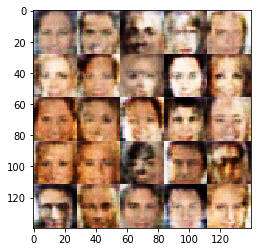

Epoch 1/1... Discriminator loss: 1.3744 Generator loss: 1.0604
Epoch 1/1... Discriminator loss: 1.4999 Generator loss: 0.8774
Epoch 1/1... Discriminator loss: 1.4560 Generator loss: 0.9071
Epoch 1/1... Discriminator loss: 1.2942 Generator loss: 0.7157
Epoch 1/1... Discriminator loss: 1.3241 Generator loss: 0.8168
Epoch 1/1... Discriminator loss: 1.3842 Generator loss: 0.9108
Epoch 1/1... Discriminator loss: 1.4310 Generator loss: 0.9623
Epoch 1/1... Discriminator loss: 1.3752 Generator loss: 0.9107
Epoch 1/1... Discriminator loss: 1.4616 Generator loss: 1.1515
Epoch 1/1... Discriminator loss: 1.2760 Generator loss: 0.9676


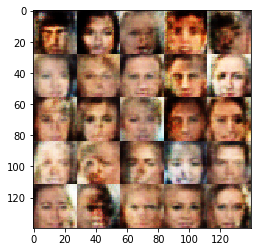

Epoch 1/1... Discriminator loss: 1.2842 Generator loss: 0.8839
Epoch 1/1... Discriminator loss: 1.3800 Generator loss: 1.1176
Epoch 1/1... Discriminator loss: 1.3314 Generator loss: 0.9969
Epoch 1/1... Discriminator loss: 1.3863 Generator loss: 0.8992
Epoch 1/1... Discriminator loss: 1.3593 Generator loss: 0.7740
Epoch 1/1... Discriminator loss: 1.3004 Generator loss: 0.7259
Epoch 1/1... Discriminator loss: 1.2677 Generator loss: 0.9052
Epoch 1/1... Discriminator loss: 1.2092 Generator loss: 0.8013
Epoch 1/1... Discriminator loss: 1.1929 Generator loss: 0.8891
Epoch 1/1... Discriminator loss: 1.4134 Generator loss: 0.9598


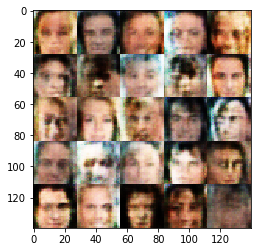

Epoch 1/1... Discriminator loss: 1.5226 Generator loss: 0.8222
Epoch 1/1... Discriminator loss: 1.3083 Generator loss: 0.9817
Epoch 1/1... Discriminator loss: 1.3186 Generator loss: 1.0594
Epoch 1/1... Discriminator loss: 1.5673 Generator loss: 0.9425
Epoch 1/1... Discriminator loss: 1.5085 Generator loss: 0.9605
Epoch 1/1... Discriminator loss: 1.3021 Generator loss: 1.0077
Epoch 1/1... Discriminator loss: 1.5132 Generator loss: 0.8141
Epoch 1/1... Discriminator loss: 1.1624 Generator loss: 0.9967
Epoch 1/1... Discriminator loss: 1.2696 Generator loss: 0.8409
Epoch 1/1... Discriminator loss: 1.3843 Generator loss: 0.8912


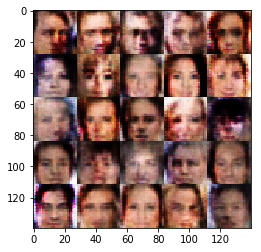

Epoch 1/1... Discriminator loss: 1.3585 Generator loss: 0.8307
Epoch 1/1... Discriminator loss: 1.3733 Generator loss: 0.9757
Epoch 1/1... Discriminator loss: 1.4028 Generator loss: 0.8073
Epoch 1/1... Discriminator loss: 1.3291 Generator loss: 0.9125
Epoch 1/1... Discriminator loss: 1.3387 Generator loss: 0.8532
Epoch 1/1... Discriminator loss: 1.3750 Generator loss: 1.1933
Epoch 1/1... Discriminator loss: 1.3383 Generator loss: 0.8178
Epoch 1/1... Discriminator loss: 1.2911 Generator loss: 0.9989
Epoch 1/1... Discriminator loss: 1.3176 Generator loss: 0.8036
Epoch 1/1... Discriminator loss: 1.5657 Generator loss: 0.9144


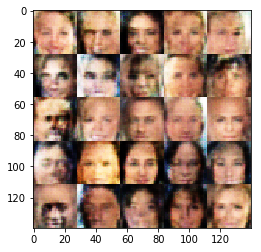

Epoch 1/1... Discriminator loss: 1.3606 Generator loss: 0.9192
Epoch 1/1... Discriminator loss: 1.2176 Generator loss: 1.0277
Epoch 1/1... Discriminator loss: 1.3730 Generator loss: 1.1796
Epoch 1/1... Discriminator loss: 1.0574 Generator loss: 1.3915
Epoch 1/1... Discriminator loss: 1.4027 Generator loss: 0.9231
Epoch 1/1... Discriminator loss: 1.3523 Generator loss: 0.6881
Epoch 1/1... Discriminator loss: 1.1983 Generator loss: 0.9816
Epoch 1/1... Discriminator loss: 1.4201 Generator loss: 0.8204
Epoch 1/1... Discriminator loss: 1.2510 Generator loss: 0.9776
Epoch 1/1... Discriminator loss: 1.2588 Generator loss: 0.9767


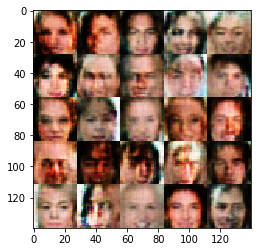

Epoch 1/1... Discriminator loss: 1.0778 Generator loss: 1.5533
Epoch 1/1... Discriminator loss: 1.3690 Generator loss: 0.6229
Epoch 1/1... Discriminator loss: 1.2287 Generator loss: 0.9836
Epoch 1/1... Discriminator loss: 1.2093 Generator loss: 1.1908
Epoch 1/1... Discriminator loss: 1.3594 Generator loss: 0.6886
Epoch 1/1... Discriminator loss: 1.2194 Generator loss: 0.9797
Epoch 1/1... Discriminator loss: 1.0706 Generator loss: 1.0626
Epoch 1/1... Discriminator loss: 1.3245 Generator loss: 0.7576
Epoch 1/1... Discriminator loss: 1.2814 Generator loss: 1.1186
Epoch 1/1... Discriminator loss: 0.9911 Generator loss: 1.6535


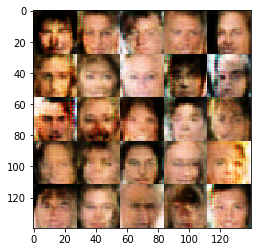

Epoch 1/1... Discriminator loss: 1.4438 Generator loss: 0.8896
Epoch 1/1... Discriminator loss: 1.4954 Generator loss: 0.9395
Epoch 1/1... Discriminator loss: 0.9877 Generator loss: 2.0614
Epoch 1/1... Discriminator loss: 1.0009 Generator loss: 1.5543
Epoch 1/1... Discriminator loss: 1.0694 Generator loss: 1.6453
Epoch 1/1... Discriminator loss: 0.9526 Generator loss: 1.1090
Epoch 1/1... Discriminator loss: 1.0479 Generator loss: 1.8978
Epoch 1/1... Discriminator loss: 1.2339 Generator loss: 0.9391
Epoch 1/1... Discriminator loss: 1.5241 Generator loss: 0.5078
Epoch 1/1... Discriminator loss: 1.1804 Generator loss: 1.1569


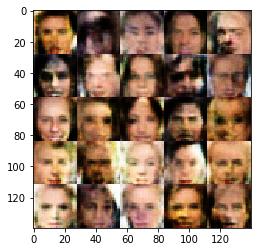

Epoch 1/1... Discriminator loss: 1.3716 Generator loss: 0.8482
Epoch 1/1... Discriminator loss: 1.3138 Generator loss: 0.8796
Epoch 1/1... Discriminator loss: 1.2911 Generator loss: 1.3876
Epoch 1/1... Discriminator loss: 1.2764 Generator loss: 0.9409
Epoch 1/1... Discriminator loss: 1.2151 Generator loss: 1.2433
Epoch 1/1... Discriminator loss: 1.2284 Generator loss: 1.0075
Epoch 1/1... Discriminator loss: 1.3343 Generator loss: 1.1621
Epoch 1/1... Discriminator loss: 1.3151 Generator loss: 0.8639
Epoch 1/1... Discriminator loss: 1.3102 Generator loss: 1.0785
Epoch 1/1... Discriminator loss: 0.9863 Generator loss: 1.0745


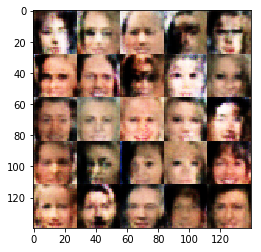

Epoch 1/1... Discriminator loss: 1.1826 Generator loss: 1.0468
Epoch 1/1... Discriminator loss: 1.1553 Generator loss: 1.1496
Epoch 1/1... Discriminator loss: 1.5572 Generator loss: 0.9228
Epoch 1/1... Discriminator loss: 1.2625 Generator loss: 1.5443
Epoch 1/1... Discriminator loss: 1.1117 Generator loss: 1.0430
Epoch 1/1... Discriminator loss: 1.3397 Generator loss: 1.2116
Epoch 1/1... Discriminator loss: 1.4120 Generator loss: 1.0136
Epoch 1/1... Discriminator loss: 1.6383 Generator loss: 0.4559
Epoch 1/1... Discriminator loss: 1.0516 Generator loss: 2.0490
Epoch 1/1... Discriminator loss: 1.3937 Generator loss: 0.7534


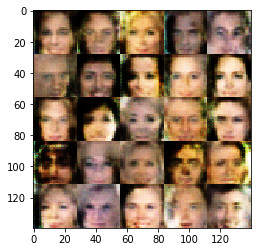

Epoch 1/1... Discriminator loss: 1.4322 Generator loss: 0.8959
Epoch 1/1... Discriminator loss: 1.4027 Generator loss: 0.6844
Epoch 1/1... Discriminator loss: 1.0440 Generator loss: 1.4368
Epoch 1/1... Discriminator loss: 1.2901 Generator loss: 0.9333
Epoch 1/1... Discriminator loss: 1.6405 Generator loss: 0.4773
Epoch 1/1... Discriminator loss: 1.1316 Generator loss: 1.2146
Epoch 1/1... Discriminator loss: 1.7488 Generator loss: 0.5447
Epoch 1/1... Discriminator loss: 1.5033 Generator loss: 0.5837
Epoch 1/1... Discriminator loss: 1.3200 Generator loss: 1.1003
Epoch 1/1... Discriminator loss: 1.5049 Generator loss: 0.7906


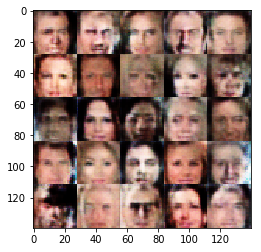

Epoch 1/1... Discriminator loss: 1.3206 Generator loss: 0.9681
Epoch 1/1... Discriminator loss: 1.5516 Generator loss: 0.8704
Epoch 1/1... Discriminator loss: 1.4297 Generator loss: 0.7666
Epoch 1/1... Discriminator loss: 1.1187 Generator loss: 1.0971
Epoch 1/1... Discriminator loss: 0.8582 Generator loss: 1.6559
Epoch 1/1... Discriminator loss: 1.3290 Generator loss: 1.2858
Epoch 1/1... Discriminator loss: 1.2894 Generator loss: 0.8138
Epoch 1/1... Discriminator loss: 1.3706 Generator loss: 1.0186
Epoch 1/1... Discriminator loss: 1.3612 Generator loss: 0.8239
Epoch 1/1... Discriminator loss: 1.4728 Generator loss: 0.9364


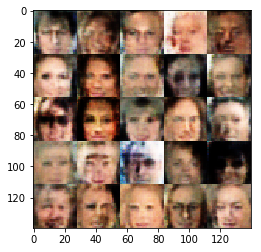

Epoch 1/1... Discriminator loss: 1.4105 Generator loss: 1.0776
Epoch 1/1... Discriminator loss: 1.5056 Generator loss: 0.9577
Epoch 1/1... Discriminator loss: 1.3697 Generator loss: 1.1920
Epoch 1/1... Discriminator loss: 1.3526 Generator loss: 1.0632
Epoch 1/1... Discriminator loss: 1.1343 Generator loss: 1.1785
Epoch 1/1... Discriminator loss: 1.3871 Generator loss: 0.6800
Epoch 1/1... Discriminator loss: 1.4415 Generator loss: 1.1666
Epoch 1/1... Discriminator loss: 1.1697 Generator loss: 1.3554
Epoch 1/1... Discriminator loss: 1.3901 Generator loss: 0.7167
Epoch 1/1... Discriminator loss: 1.3864 Generator loss: 0.7710


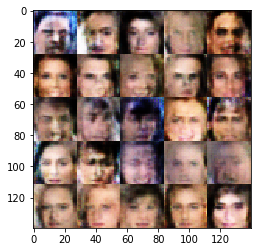

Epoch 1/1... Discriminator loss: 1.2624 Generator loss: 0.9336
Epoch 1/1... Discriminator loss: 1.4453 Generator loss: 0.7498
Epoch 1/1... Discriminator loss: 1.3149 Generator loss: 0.9488
Epoch 1/1... Discriminator loss: 1.2611 Generator loss: 0.9504
Epoch 1/1... Discriminator loss: 1.3202 Generator loss: 0.7484
Epoch 1/1... Discriminator loss: 1.4781 Generator loss: 0.7062
Epoch 1/1... Discriminator loss: 1.2137 Generator loss: 1.1225
Epoch 1/1... Discriminator loss: 1.2171 Generator loss: 1.0162
Epoch 1/1... Discriminator loss: 1.4253 Generator loss: 1.1473
Epoch 1/1... Discriminator loss: 1.2946 Generator loss: 1.0357


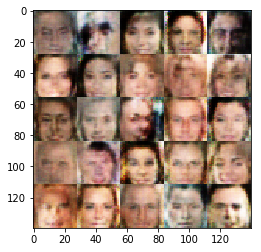

Epoch 1/1... Discriminator loss: 1.1681 Generator loss: 0.9315
Epoch 1/1... Discriminator loss: 1.3235 Generator loss: 0.8958
Epoch 1/1... Discriminator loss: 1.3605 Generator loss: 0.8181
Epoch 1/1... Discriminator loss: 1.1840 Generator loss: 0.9649
Epoch 1/1... Discriminator loss: 1.4519 Generator loss: 1.0884
Epoch 1/1... Discriminator loss: 1.5298 Generator loss: 0.6708
Epoch 1/1... Discriminator loss: 1.3092 Generator loss: 0.7190
Epoch 1/1... Discriminator loss: 1.4356 Generator loss: 0.6927
Epoch 1/1... Discriminator loss: 1.6458 Generator loss: 0.6610
Epoch 1/1... Discriminator loss: 1.3721 Generator loss: 1.0147


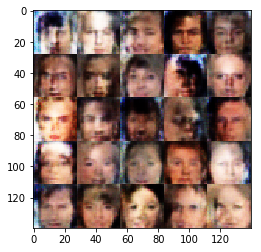

Epoch 1/1... Discriminator loss: 1.4522 Generator loss: 0.8667
Epoch 1/1... Discriminator loss: 1.3360 Generator loss: 0.7622
Epoch 1/1... Discriminator loss: 1.3400 Generator loss: 0.8583
Epoch 1/1... Discriminator loss: 1.1902 Generator loss: 1.0002
Epoch 1/1... Discriminator loss: 1.3035 Generator loss: 0.8440
Epoch 1/1... Discriminator loss: 1.3916 Generator loss: 0.9883
Epoch 1/1... Discriminator loss: 1.3629 Generator loss: 0.9603
Epoch 1/1... Discriminator loss: 1.3556 Generator loss: 0.8411
Epoch 1/1... Discriminator loss: 1.3947 Generator loss: 0.7916
Epoch 1/1... Discriminator loss: 1.1183 Generator loss: 1.2165


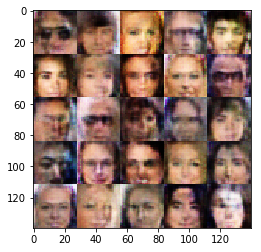

Epoch 1/1... Discriminator loss: 1.3453 Generator loss: 0.9430
Epoch 1/1... Discriminator loss: 1.4919 Generator loss: 0.8143
Epoch 1/1... Discriminator loss: 1.5282 Generator loss: 0.7458
Epoch 1/1... Discriminator loss: 1.3549 Generator loss: 0.8645
Epoch 1/1... Discriminator loss: 1.1107 Generator loss: 1.2948
Epoch 1/1... Discriminator loss: 1.4522 Generator loss: 0.8018
Epoch 1/1... Discriminator loss: 1.4376 Generator loss: 0.8585
Epoch 1/1... Discriminator loss: 1.2542 Generator loss: 0.7953
Epoch 1/1... Discriminator loss: 1.3257 Generator loss: 0.9751
Epoch 1/1... Discriminator loss: 1.3745 Generator loss: 0.6709


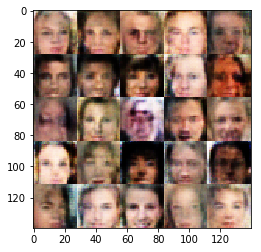

Epoch 1/1... Discriminator loss: 1.3584 Generator loss: 0.9558
Epoch 1/1... Discriminator loss: 1.3767 Generator loss: 0.9662
Epoch 1/1... Discriminator loss: 1.4738 Generator loss: 0.8572
Epoch 1/1... Discriminator loss: 1.3870 Generator loss: 0.7024
Epoch 1/1... Discriminator loss: 1.3187 Generator loss: 1.1661
Epoch 1/1... Discriminator loss: 1.3657 Generator loss: 0.8231
Epoch 1/1... Discriminator loss: 1.3978 Generator loss: 0.7671
Epoch 1/1... Discriminator loss: 1.4304 Generator loss: 0.9150
Epoch 1/1... Discriminator loss: 1.3561 Generator loss: 1.1732
Epoch 1/1... Discriminator loss: 1.3499 Generator loss: 0.7454


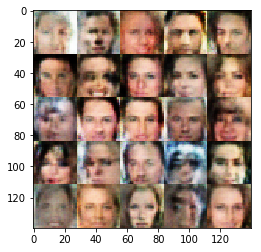

Epoch 1/1... Discriminator loss: 1.5772 Generator loss: 0.8525
Epoch 1/1... Discriminator loss: 1.4028 Generator loss: 0.7800
Epoch 1/1... Discriminator loss: 1.4081 Generator loss: 0.7878
Epoch 1/1... Discriminator loss: 1.3268 Generator loss: 1.0567
Epoch 1/1... Discriminator loss: 1.4868 Generator loss: 1.1116
Epoch 1/1... Discriminator loss: 1.4940 Generator loss: 0.8320
Epoch 1/1... Discriminator loss: 1.4180 Generator loss: 1.0802
Epoch 1/1... Discriminator loss: 1.4066 Generator loss: 0.8443
Epoch 1/1... Discriminator loss: 1.2746 Generator loss: 0.7828
Epoch 1/1... Discriminator loss: 1.2791 Generator loss: 1.0193


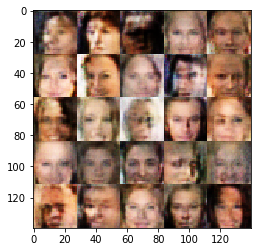

Epoch 1/1... Discriminator loss: 1.1555 Generator loss: 0.8294
Epoch 1/1... Discriminator loss: 1.2777 Generator loss: 0.7768
Epoch 1/1... Discriminator loss: 1.2465 Generator loss: 0.9495
Epoch 1/1... Discriminator loss: 1.4319 Generator loss: 0.8644
Epoch 1/1... Discriminator loss: 1.4289 Generator loss: 0.7722
Epoch 1/1... Discriminator loss: 1.4646 Generator loss: 0.8900
Epoch 1/1... Discriminator loss: 1.2715 Generator loss: 1.0241
Epoch 1/1... Discriminator loss: 1.4068 Generator loss: 0.8461
Epoch 1/1... Discriminator loss: 1.4287 Generator loss: 0.6720
Epoch 1/1... Discriminator loss: 1.3575 Generator loss: 0.8196


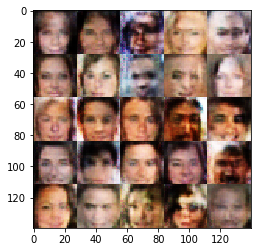

Epoch 1/1... Discriminator loss: 1.2867 Generator loss: 0.7975
Epoch 1/1... Discriminator loss: 1.3960 Generator loss: 1.0237
Epoch 1/1... Discriminator loss: 1.3543 Generator loss: 0.6946
Epoch 1/1... Discriminator loss: 1.2341 Generator loss: 0.8087
Epoch 1/1... Discriminator loss: 1.3479 Generator loss: 0.9270
Epoch 1/1... Discriminator loss: 1.2712 Generator loss: 0.7731
Epoch 1/1... Discriminator loss: 1.3529 Generator loss: 0.9774
Epoch 1/1... Discriminator loss: 1.4652 Generator loss: 0.7524
Epoch 1/1... Discriminator loss: 1.3306 Generator loss: 1.0666
Epoch 1/1... Discriminator loss: 1.3391 Generator loss: 0.8710


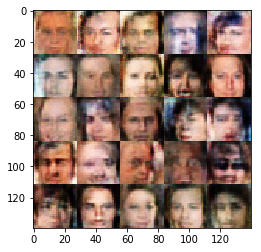

Epoch 1/1... Discriminator loss: 1.4568 Generator loss: 0.8770
Epoch 1/1... Discriminator loss: 1.4039 Generator loss: 0.8857
Epoch 1/1... Discriminator loss: 1.4210 Generator loss: 0.8663
Epoch 1/1... Discriminator loss: 1.4342 Generator loss: 0.9179
Epoch 1/1... Discriminator loss: 1.4398 Generator loss: 0.8673
Epoch 1/1... Discriminator loss: 1.5064 Generator loss: 0.7990
Epoch 1/1... Discriminator loss: 1.3637 Generator loss: 0.8865
Epoch 1/1... Discriminator loss: 1.5136 Generator loss: 0.8115
Epoch 1/1... Discriminator loss: 1.5685 Generator loss: 0.8004
Epoch 1/1... Discriminator loss: 1.3143 Generator loss: 0.9548


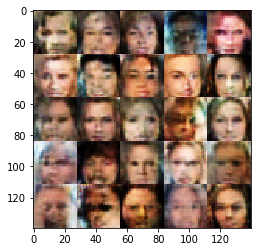

Epoch 1/1... Discriminator loss: 1.4479 Generator loss: 0.9952
Epoch 1/1... Discriminator loss: 1.4450 Generator loss: 0.8097
Epoch 1/1... Discriminator loss: 1.3655 Generator loss: 0.7995
Epoch 1/1... Discriminator loss: 1.2266 Generator loss: 0.9757
Epoch 1/1... Discriminator loss: 1.5606 Generator loss: 0.8764
Epoch 1/1... Discriminator loss: 1.4935 Generator loss: 0.8308
Epoch 1/1... Discriminator loss: 1.4211 Generator loss: 0.9113
Epoch 1/1... Discriminator loss: 1.3738 Generator loss: 0.9219
Epoch 1/1... Discriminator loss: 1.2400 Generator loss: 0.9654
Epoch 1/1... Discriminator loss: 1.4483 Generator loss: 0.6819


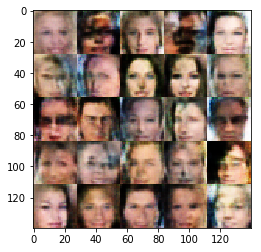

Epoch 1/1... Discriminator loss: 1.4936 Generator loss: 0.8761
Epoch 1/1... Discriminator loss: 1.4412 Generator loss: 0.9320
Epoch 1/1... Discriminator loss: 1.3074 Generator loss: 0.8184
Epoch 1/1... Discriminator loss: 1.3606 Generator loss: 0.8473
Epoch 1/1... Discriminator loss: 1.3669 Generator loss: 0.8043
Epoch 1/1... Discriminator loss: 1.3009 Generator loss: 0.8342
Epoch 1/1... Discriminator loss: 1.4593 Generator loss: 0.7575
Epoch 1/1... Discriminator loss: 1.2553 Generator loss: 0.8570
Epoch 1/1... Discriminator loss: 1.1767 Generator loss: 1.1181
Epoch 1/1... Discriminator loss: 1.4087 Generator loss: 0.8488


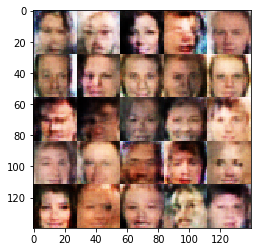

Epoch 1/1... Discriminator loss: 1.2476 Generator loss: 0.8019
Epoch 1/1... Discriminator loss: 1.3078 Generator loss: 0.8074
Epoch 1/1... Discriminator loss: 1.3378 Generator loss: 0.9289
Epoch 1/1... Discriminator loss: 1.3352 Generator loss: 0.9949
Epoch 1/1... Discriminator loss: 1.3243 Generator loss: 0.9230
Epoch 1/1... Discriminator loss: 1.2507 Generator loss: 0.8862
Epoch 1/1... Discriminator loss: 1.4600 Generator loss: 0.7869
Epoch 1/1... Discriminator loss: 1.3912 Generator loss: 0.9105
Epoch 1/1... Discriminator loss: 1.4669 Generator loss: 0.8303
Epoch 1/1... Discriminator loss: 1.2719 Generator loss: 0.9387


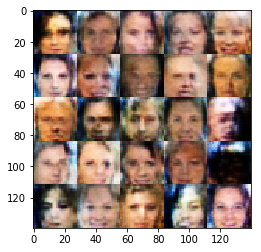

Epoch 1/1... Discriminator loss: 1.4382 Generator loss: 0.6323
Epoch 1/1... Discriminator loss: 1.4515 Generator loss: 0.8600
Epoch 1/1... Discriminator loss: 1.5425 Generator loss: 0.8231
Epoch 1/1... Discriminator loss: 1.3850 Generator loss: 0.8430
Epoch 1/1... Discriminator loss: 1.2494 Generator loss: 1.0169
Epoch 1/1... Discriminator loss: 1.3797 Generator loss: 0.7594
Epoch 1/1... Discriminator loss: 1.3143 Generator loss: 0.7940
Epoch 1/1... Discriminator loss: 1.5558 Generator loss: 0.8716
Epoch 1/1... Discriminator loss: 1.2860 Generator loss: 0.8851
Epoch 1/1... Discriminator loss: 1.3667 Generator loss: 0.7622


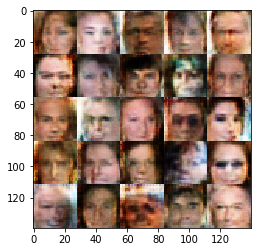

Epoch 1/1... Discriminator loss: 1.2962 Generator loss: 0.8922
Epoch 1/1... Discriminator loss: 1.4152 Generator loss: 0.8655
Epoch 1/1... Discriminator loss: 1.5647 Generator loss: 0.7307
Epoch 1/1... Discriminator loss: 1.2297 Generator loss: 0.9118
Epoch 1/1... Discriminator loss: 1.4709 Generator loss: 1.0034
Epoch 1/1... Discriminator loss: 1.3716 Generator loss: 0.8557
Epoch 1/1... Discriminator loss: 1.4264 Generator loss: 0.8334
Epoch 1/1... Discriminator loss: 1.5871 Generator loss: 0.7492
Epoch 1/1... Discriminator loss: 1.5943 Generator loss: 0.8561
Epoch 1/1... Discriminator loss: 1.4054 Generator loss: 0.8437


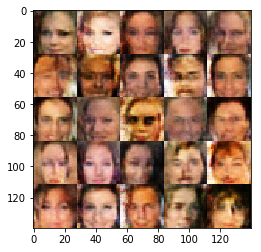

Epoch 1/1... Discriminator loss: 1.5315 Generator loss: 0.8113
Epoch 1/1... Discriminator loss: 1.2532 Generator loss: 0.9813
Epoch 1/1... Discriminator loss: 1.4805 Generator loss: 0.9166
Epoch 1/1... Discriminator loss: 1.2177 Generator loss: 1.1279
Epoch 1/1... Discriminator loss: 1.2923 Generator loss: 0.9971
Epoch 1/1... Discriminator loss: 1.3145 Generator loss: 0.7715
Epoch 1/1... Discriminator loss: 1.4213 Generator loss: 0.8323
Epoch 1/1... Discriminator loss: 1.3494 Generator loss: 0.9744
Epoch 1/1... Discriminator loss: 1.3483 Generator loss: 0.7603
Epoch 1/1... Discriminator loss: 1.2437 Generator loss: 0.9629


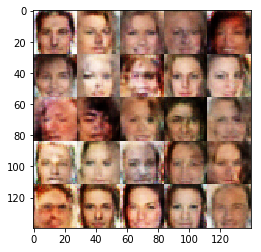

Epoch 1/1... Discriminator loss: 1.3581 Generator loss: 0.8082
Epoch 1/1... Discriminator loss: 1.2704 Generator loss: 0.9761
Epoch 1/1... Discriminator loss: 1.3712 Generator loss: 0.7310
Epoch 1/1... Discriminator loss: 1.3428 Generator loss: 0.8514
Epoch 1/1... Discriminator loss: 1.4232 Generator loss: 0.6744
Epoch 1/1... Discriminator loss: 1.2728 Generator loss: 0.9052
Epoch 1/1... Discriminator loss: 1.3985 Generator loss: 1.0761
Epoch 1/1... Discriminator loss: 1.3400 Generator loss: 0.8917
Epoch 1/1... Discriminator loss: 1.4493 Generator loss: 0.9275
Epoch 1/1... Discriminator loss: 1.3669 Generator loss: 0.8373


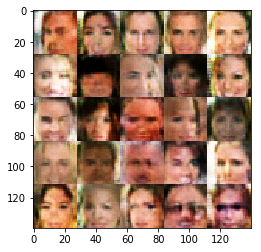

Epoch 1/1... Discriminator loss: 1.4149 Generator loss: 0.8446
Epoch 1/1... Discriminator loss: 1.3977 Generator loss: 0.8851
Epoch 1/1... Discriminator loss: 1.4240 Generator loss: 0.7476
Epoch 1/1... Discriminator loss: 1.5072 Generator loss: 0.8444
Epoch 1/1... Discriminator loss: 1.3297 Generator loss: 0.8326
Epoch 1/1... Discriminator loss: 1.4518 Generator loss: 0.7495
Epoch 1/1... Discriminator loss: 1.4648 Generator loss: 0.8841
Epoch 1/1... Discriminator loss: 1.3420 Generator loss: 0.9176
Epoch 1/1... Discriminator loss: 1.3435 Generator loss: 0.7848
Epoch 1/1... Discriminator loss: 1.3066 Generator loss: 0.9306


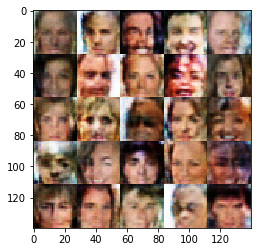

Epoch 1/1... Discriminator loss: 1.4009 Generator loss: 0.9272
Epoch 1/1... Discriminator loss: 1.4265 Generator loss: 0.9097
Epoch 1/1... Discriminator loss: 1.3905 Generator loss: 0.7147
Epoch 1/1... Discriminator loss: 1.3262 Generator loss: 0.9412
Epoch 1/1... Discriminator loss: 1.3917 Generator loss: 0.6803
Epoch 1/1... Discriminator loss: 1.5037 Generator loss: 0.8598
Epoch 1/1... Discriminator loss: 1.2761 Generator loss: 0.8633
Epoch 1/1... Discriminator loss: 1.3793 Generator loss: 0.8563
Epoch 1/1... Discriminator loss: 1.3888 Generator loss: 0.8738
Epoch 1/1... Discriminator loss: 1.3487 Generator loss: 0.7978


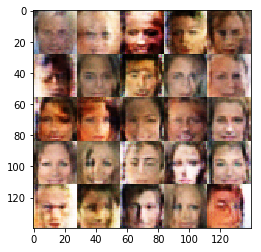

Epoch 1/1... Discriminator loss: 1.3813 Generator loss: 0.9210
Epoch 1/1... Discriminator loss: 1.2729 Generator loss: 0.9335
Epoch 1/1... Discriminator loss: 1.3115 Generator loss: 0.9598
Epoch 1/1... Discriminator loss: 1.2065 Generator loss: 0.9791
Epoch 1/1... Discriminator loss: 1.5050 Generator loss: 0.8404
Epoch 1/1... Discriminator loss: 1.3520 Generator loss: 0.9372
Epoch 1/1... Discriminator loss: 1.3067 Generator loss: 0.7847
Epoch 1/1... Discriminator loss: 1.4250 Generator loss: 0.7649
Epoch 1/1... Discriminator loss: 1.3378 Generator loss: 0.8802
Epoch 1/1... Discriminator loss: 1.4262 Generator loss: 0.7483


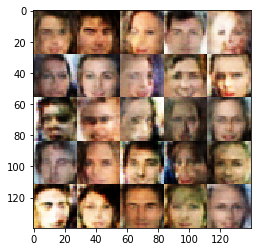

Epoch 1/1... Discriminator loss: 1.3158 Generator loss: 0.9235
Epoch 1/1... Discriminator loss: 1.2022 Generator loss: 1.0467
Epoch 1/1... Discriminator loss: 1.2623 Generator loss: 0.9514
Epoch 1/1... Discriminator loss: 1.4062 Generator loss: 0.7906
Epoch 1/1... Discriminator loss: 1.1476 Generator loss: 1.2021
Epoch 1/1... Discriminator loss: 1.3667 Generator loss: 0.8925
Epoch 1/1... Discriminator loss: 1.3718 Generator loss: 0.7307
Epoch 1/1... Discriminator loss: 1.2825 Generator loss: 1.0093
Epoch 1/1... Discriminator loss: 1.3667 Generator loss: 0.9200
Epoch 1/1... Discriminator loss: 1.2808 Generator loss: 0.8645


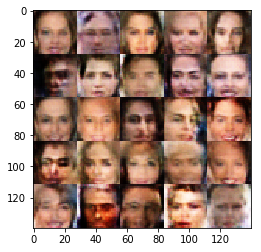

Epoch 1/1... Discriminator loss: 1.3649 Generator loss: 0.6894
Epoch 1/1... Discriminator loss: 1.3755 Generator loss: 0.8652
Epoch 1/1... Discriminator loss: 1.3721 Generator loss: 0.8427
Epoch 1/1... Discriminator loss: 1.3540 Generator loss: 0.9783
Epoch 1/1... Discriminator loss: 1.4671 Generator loss: 0.9521
Epoch 1/1... Discriminator loss: 1.5395 Generator loss: 0.8002
Epoch 1/1... Discriminator loss: 1.3276 Generator loss: 0.8446
Epoch 1/1... Discriminator loss: 1.3133 Generator loss: 0.7025
Epoch 1/1... Discriminator loss: 1.2751 Generator loss: 0.8934
Epoch 1/1... Discriminator loss: 1.4369 Generator loss: 0.8904


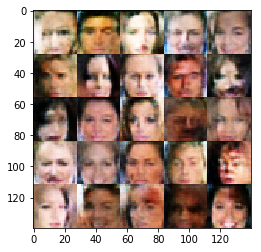

Epoch 1/1... Discriminator loss: 1.3937 Generator loss: 0.7773
Epoch 1/1... Discriminator loss: 1.3372 Generator loss: 0.8296
Epoch 1/1... Discriminator loss: 1.3285 Generator loss: 0.8991
Epoch 1/1... Discriminator loss: 1.3872 Generator loss: 1.0031
Epoch 1/1... Discriminator loss: 1.2982 Generator loss: 0.7905
Epoch 1/1... Discriminator loss: 1.1960 Generator loss: 1.0531
Epoch 1/1... Discriminator loss: 1.2517 Generator loss: 0.9714
Epoch 1/1... Discriminator loss: 1.2683 Generator loss: 0.9474
Epoch 1/1... Discriminator loss: 1.4546 Generator loss: 0.9733
Epoch 1/1... Discriminator loss: 1.3006 Generator loss: 0.9639


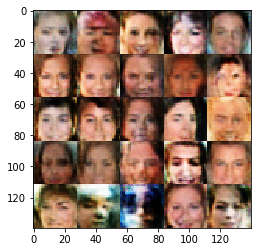

Epoch 1/1... Discriminator loss: 1.4950 Generator loss: 0.6699
Epoch 1/1... Discriminator loss: 1.3177 Generator loss: 0.8046
Epoch 1/1... Discriminator loss: 1.2933 Generator loss: 0.8376
Epoch 1/1... Discriminator loss: 1.2791 Generator loss: 0.9562
Epoch 1/1... Discriminator loss: 1.3606 Generator loss: 1.0434
Epoch 1/1... Discriminator loss: 0.9678 Generator loss: 1.4119
Epoch 1/1... Discriminator loss: 1.2745 Generator loss: 0.7713
Epoch 1/1... Discriminator loss: 1.4480 Generator loss: 0.9550
Epoch 1/1... Discriminator loss: 1.3782 Generator loss: 0.7519
Epoch 1/1... Discriminator loss: 1.4206 Generator loss: 0.7990


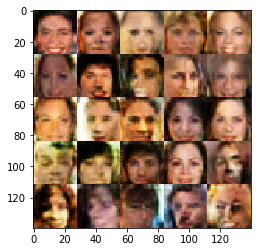

Epoch 1/1... Discriminator loss: 1.2083 Generator loss: 0.8793
Epoch 1/1... Discriminator loss: 1.1395 Generator loss: 0.9706
Epoch 1/1... Discriminator loss: 1.1579 Generator loss: 1.0276
Epoch 1/1... Discriminator loss: 1.2368 Generator loss: 1.1465
Epoch 1/1... Discriminator loss: 1.2298 Generator loss: 0.9280
Epoch 1/1... Discriminator loss: 1.4449 Generator loss: 0.7098
Epoch 1/1... Discriminator loss: 1.5009 Generator loss: 0.8589
Epoch 1/1... Discriminator loss: 1.2135 Generator loss: 1.0192
Epoch 1/1... Discriminator loss: 1.3867 Generator loss: 0.8943
Epoch 1/1... Discriminator loss: 1.2443 Generator loss: 1.3279


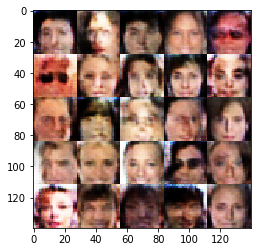

Epoch 1/1... Discriminator loss: 1.3276 Generator loss: 0.8794
Epoch 1/1... Discriminator loss: 1.2856 Generator loss: 0.8743
Epoch 1/1... Discriminator loss: 1.3717 Generator loss: 0.8115
Epoch 1/1... Discriminator loss: 1.2452 Generator loss: 0.8643
Epoch 1/1... Discriminator loss: 1.2533 Generator loss: 0.8508
Epoch 1/1... Discriminator loss: 1.3844 Generator loss: 0.8382
Epoch 1/1... Discriminator loss: 1.0338 Generator loss: 1.2174
Epoch 1/1... Discriminator loss: 1.1740 Generator loss: 0.9342
Epoch 1/1... Discriminator loss: 1.4039 Generator loss: 0.7841
Epoch 1/1... Discriminator loss: 1.1522 Generator loss: 1.1874


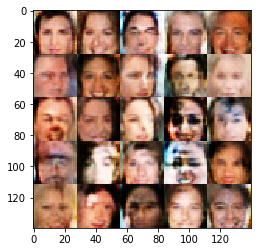

Epoch 1/1... Discriminator loss: 1.1424 Generator loss: 1.1615
Epoch 1/1... Discriminator loss: 1.1123 Generator loss: 1.1822
Epoch 1/1... Discriminator loss: 1.2430 Generator loss: 1.0716
Epoch 1/1... Discriminator loss: 1.1833 Generator loss: 1.4270
Epoch 1/1... Discriminator loss: 1.2417 Generator loss: 0.7885
Epoch 1/1... Discriminator loss: 1.0162 Generator loss: 1.1092
Epoch 1/1... Discriminator loss: 1.3678 Generator loss: 0.8591
Epoch 1/1... Discriminator loss: 1.5519 Generator loss: 0.7783
Epoch 1/1... Discriminator loss: 1.1223 Generator loss: 0.9651
Epoch 1/1... Discriminator loss: 1.4270 Generator loss: 1.1003


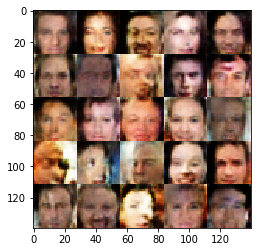

Epoch 1/1... Discriminator loss: 1.5551 Generator loss: 0.5869
Epoch 1/1... Discriminator loss: 1.1927 Generator loss: 1.0613
Epoch 1/1... Discriminator loss: 1.3254 Generator loss: 0.6756
Epoch 1/1... Discriminator loss: 1.3131 Generator loss: 1.0147
Epoch 1/1... Discriminator loss: 1.1735 Generator loss: 0.9074
Epoch 1/1... Discriminator loss: 1.3805 Generator loss: 0.7948
Epoch 1/1... Discriminator loss: 1.3494 Generator loss: 1.1656
Epoch 1/1... Discriminator loss: 1.4192 Generator loss: 0.5913
Epoch 1/1... Discriminator loss: 1.3617 Generator loss: 0.6716
Epoch 1/1... Discriminator loss: 1.0906 Generator loss: 1.1852


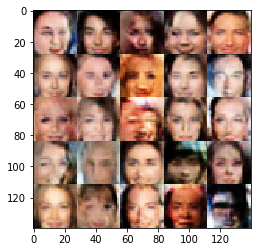

Epoch 1/1... Discriminator loss: 1.1556 Generator loss: 1.4528
Epoch 1/1... Discriminator loss: 1.1601 Generator loss: 1.2592
Epoch 1/1... Discriminator loss: 1.1527 Generator loss: 0.9006
Epoch 1/1... Discriminator loss: 1.2312 Generator loss: 0.9717
Epoch 1/1... Discriminator loss: 1.3554 Generator loss: 0.9391
Epoch 1/1... Discriminator loss: 1.3146 Generator loss: 0.8150
Epoch 1/1... Discriminator loss: 1.0387 Generator loss: 1.3873
Epoch 1/1... Discriminator loss: 1.2823 Generator loss: 1.0933
Epoch 1/1... Discriminator loss: 1.4119 Generator loss: 0.9205
Epoch 1/1... Discriminator loss: 1.2471 Generator loss: 0.7664


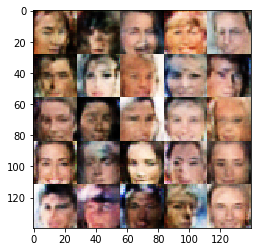

Epoch 1/1... Discriminator loss: 1.4269 Generator loss: 0.8822
Epoch 1/1... Discriminator loss: 1.3909 Generator loss: 0.9606
Epoch 1/1... Discriminator loss: 1.2321 Generator loss: 0.7980
Complete training!


In [12]:
batch_size = 32
z_dim = 100
learning_rate = (0.00005, 0.0002)
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.